# Face Recognition Project

В этом проектк вы познакомитесь с задачей распознавания лиц, узнаете, как ее решать, и построите свой пайплан для решения этой задачи.

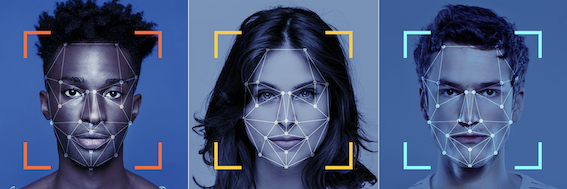

Для начала познакомимся с тем, как работает стандартный пайплан для распознавания лиц. Это не одна нейросеть, которая делает всю работу: это целых три отдельных стадии. После этого в разделе "задача проекта" расписано то, что нужно/можно делать в рамках этого проекта. **Пожалуйста, перед началом работы по проекту внимательно прочитайте раздел "задача проекта"!**

Ну а перед этим всем лучше разберемся с тем, какую задачу вообще мы хотим решать.

## Постановка задачи

Допустим, вы владеете компанией и хотите разработать систему распознавания лиц, чтобы применять ее в своем офисе. Например, чтобы ваши сотрудники могли сканировать лицо вместо прикладывания id карточек к турникетам при входе. Или для обеспечения безопасности в офисах (да, вы — хороший владелец компании, и используете face recognition только для обеспечения безопасности. Никакие данные не собираете, нигде долго не храните и никуда не передаете)  

Получается, вам нужна система, которая может принимать на вход видео, полученное с камер наблюдения, и на выходе выдавать, что за люди были замечены на этом видео. Ваша система должна уметь работать в случаях, когда лица людей запечатлены крупным или мелким планом, когда они чуть повернуты или наклонены, и когда на одном кадре с камеры находятся несколько лиц людей.

Вот решением такой задачи мы сейчас и займемся.

## Пайплайн для распознавания лиц, его обучение и тест

В этой части описано устройство пайплайна для распознавания лиц, а также принцип его обучения и тестирования.

### Пайплайн распознавания лиц

Обычно система распознавания лиц состоит из трех элементов:

- детекция лица (face detection);
- выравнивание лица (face alignment);
- распознавания лица (face recognition).

Давайте обсудим все этапы подробнее:

#### Детекция лиц

Пусть мы получили кадр с камеры наблюдения, на котором мы хотим распознать лица. Этот кадр может выглядеть как-то так:

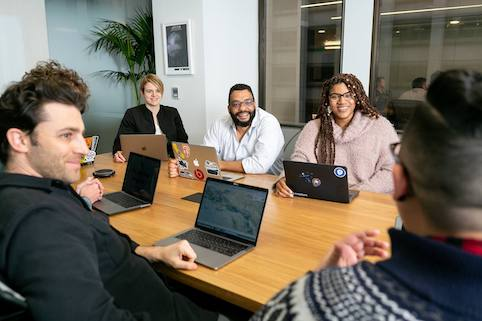

Первый этап обработки фото — детекция лиц на нем. Результат детекции может выглядеть примерно так:

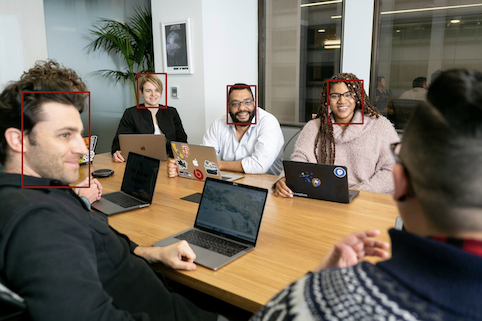

Для детекции лиц на фото может использоваться модель (например, нейросеть), обученная на задачу детекции лиц людей.

#### Выравнивание лиц


После этапа детекции работа с каждым детектированным лицом идет по отдельности
(точнее, с bounding box'ами каждого детектированного лица).

Второй этап — выравнивание лица. Он состоит из двух этапов:
1. На картинке ищутся ключевые точки лица (обычно это координаты зрачков глаз, кончик носа и точки вокруг рта). Для этой задачи используется отдельная модель (возможно, тоже нейросеть). У PyTorch есть [туториал](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) с кодом и описанием того, как подобная модель работает;
2. Повернуть и растянуть изображение так, чтобы точки глаз лица лежали на заданной горизонтальной линии, и чтобы между зрачками глаз было определенное расстояние.

Вот так это может выглядеть:

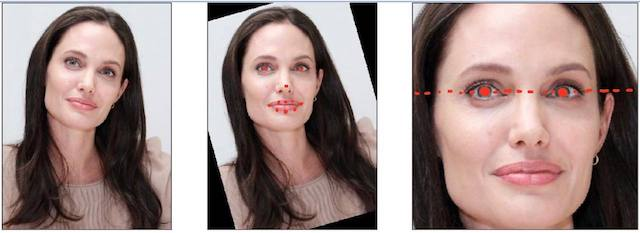

Таким образом, после второго этапа лица выглядят как-то так:

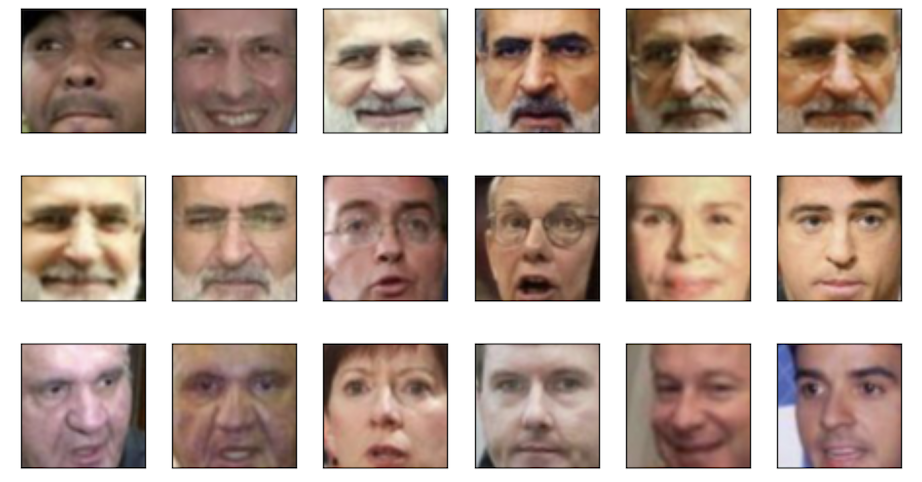

На таких картинках лиц и будет работать третья часть пайплайна — нейросеть, которая распознает лица.

**Зачем нужна стадия выравнивания**: выравнивание лиц датасета делает задачу распознавания лиц проще для модели на третьей стадии пайплайна. Если у всех лиц, которые принимает на вход модель, примерно одинаковый размер и все ключевые части (глаза, нос, рот) находятся в примерно одинаковых местах, это упрощает модели задачу понимания того, что за человек изображен на картинке. Модели не нужно "искать" глаза, рот и т.п. на картинке.

Практика подтверждает, что это сильно улучшает эффективность модели: без стадии выравнивания практически невозможно обучить хорошую систему распознавания лиц. Точнее, возможно, но только если есть очень-очень-очень много обучающих данных. Больше, чем практически у всех даже больших компаний.

#### Распознавание лиц

Третья часть пайплайна — это, собственно, распознавание лиц.

Что такое "распознавание": мы хотим построить такую нейросеть, которая принимает на вход картинку лица, а выдает вектор определенного размера. И мы хотим, чтобы векторы лиц одного и того же человека были близки по некоторому расстоянию (например, косинусному), а векторы лиц разных людей были далеки по этому же расстоянию. Обычно в качестве расстояния используется [косинусное расстояние](https://en.wikipedia.org/wiki/Cosine_similarity) (cosine distance).

Почему мы хотим построить именно такую сеть? Почему не посмтроить обычную сеть для классификации и научить ее классифицировать лица из обучающей выборки, где каждый отдельный человек — это один класс? Ответ такой — мы хотим, чтобы наша модель умела работать с лицами людей, которых нет в обучающей выборке. Хотим, чтобы она на лица одного и того же незнакомого человека выдавала близкие векторы (т.е. "говорила" нам, что это один и тот же человек), а на лица разных людей — далекие векторы.

Пусть тогда у нас есть база данных людей вида (id, набор векторов его лиц). Когда к нам придет новая картинка лица, мы ее прогоним через модель и получим вектор этого лица. Далее сравним этот вектор по метрике расстояния с векторами из нашей базы. Тот id, чьи векторы будут наиболее близки к нашему, и будет ответом на вопрос "кто изображен на картинке"



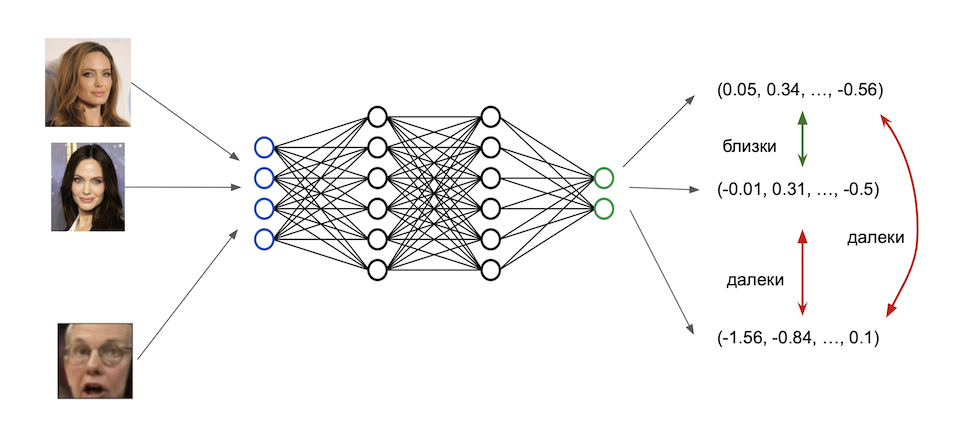

Такую сеть можно обучать разными способами. Два самых распространенных — такие:

1. Можно обучить нейросеть на обучающей выборке лиц на задачу классификации. Каждый отдельный человек — это один класс. В качестве лосс-функции можно использовать стандартную кросс-энтропию или специальные ее модификации (разберем ниже в ноутбуке). Затем, после обучения сети, выкинуть последний слой и считать вектором лица выход предпоследнего слоя сети. Это будет работать: полученные таким образом векторы лиц действительно будут близки для лиц одного и того же человека, и далеки для лиц разных людей. Причем это будет работать даже на тех лицах, которые не было в обучающей выборке (при условии, что обучающая выборка достаточно велика).

    У этого подхода есть недостаток: классов в обучающем датасете может быть очень много. Из-за этого последний слой сети станет очень широким. Это сделает обучение сети вычислительно затратным и сложным по памяти. Иногда приходится этот последний слой делить на несколько разных GPU, настолько он бывает большим.
2.  Можно пойти другим путем: обучать сеть напрямую на задачу "выдавать похожие эмбеддинги для лиц одного и того же человека, и далекие эмбеддинги для лиц разных людей". Это называется **contrastive training**.
    
    На каждой итерации обучения тогда происходит следующее:
    - берется картинка лица, к ней выбирается позитивная пара (еще одна картинка лица того же человека) и негативная (картинка лица другого человека). Все три картинки подаются на вход сети, на выходе получаются три вектора. Далее считается расстояние между векторами 1 и 2 и расстояние между векторами 1 и 3. Нейросеть обучается так, чтобы расстояние между векторами 1 и 2 было как можно меньше, а расстояние между векторами 1 и 3 — как можно больше.

    Лосс-функция в этом случае выглядит так:

 $$L = D(anchor, positive) - D(anchor, negative)$$

У contrastive loss тоже есть недостаток: его достаточно сложно настроить (подобрать к нему гиперпараметры).

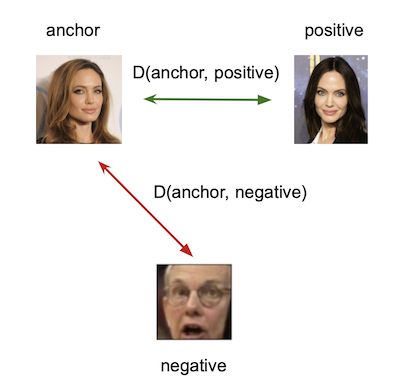

Вот так устроен пайплайн распознавания лиц, который мы хотим получить. Заметим, что все три части пайплайна обучаются отдельно.
- первая часть — это просто задача детекции;
- вторая часть — задача выравнивания фотографии лица;
- третья часть — задача распознавания лица по выровненной фотографии.

### Метрика качества для 3 части пайплайна

При обучении модели для распознавания лиц с помощью CE (кросс-энтропии) мы можем считать метрику accuracy как индикатор того, насколько хорошо наша модель работает. Но у accuracy тут есть недостаток: она не сможет померить, насколько хорошо наша модель работает на лицах людей, которых нет в обучающей выборке.  

Чтобы это исправить, придумали новую метрику: **identification rate**. Вот как она работает:

Создадим два набора изображений лиц: query и distractors. Никакие лица из этих наборов не должны содержаться в обучающем и валидационном датасете.

1. посчитаем косинусные расстояния между лицами, соответствующими одним и тем же людям из query части. Например, пусть одному человеку соответствуют три фото в query: 01.jpg, 02.jpg, 03.jpg. Тогда считаем три косинусных расстояния между всеми тремя парами из этих фото.
2. посчитаем косинусные расстояния между лицами, соответствующими разным людям из query части.
3. посчитаем косинусные расстояния между всеми парами лиц из query и distractors. Т.е. пара — это (лицо из query, лицо из distractors). Всего получится |query|*|distractors| пар.
4. Сложим количества пар, полученных на 2 и 3 шагах. Это количество false пар.
5. Зафиксируем **FPR** (false positive rate). Пусть, например, будет 0.01. FPR, умноженный на количество false пар из шага 4 — это разрешенное количество false positives, которые мы разрешаем нашей модели. Обозначим это количество через N.
6. Отсортируем все значения косинусных расстояний false пар. N — ое по счету значение расстояния зафиксируем как **пороговое расстояние**.
7. Посчитаем количество positive пар с шага 1, которые имеют косинусное расстояние меньше, чем пороговое расстояние. Поделим это количество на общее количество positive пар с шага 1. Это будет TPR (true positive rate) — итоговое значение нашей метрики.

Такая метрика обычно обозначается как TPR@FPR=0.01. FPR может быть разным. При разных FPR будет получаться разное TPR.

Смысл этой метрики в том, что мы фиксируем вероятность ошибки вида false positive, т.е. когда "сеть сказала, что это один и тот же человек, но это не так", считаем порог косинусного расстояния для этого значения ошибки, потом берем все positive пары и смотрим, у скольких из них расстояние меньше этого порога. Т.е. насколько точно наша сеть ищет похожие лица при заданной вероятности ошибки вида false positive.

### Лосс-функции для 3 части пайплайна

Выше мы поняли, что нейросеть для распознавания лиц можно обучать разными способами. Два, которые мы упомянули — обучение сети на задачу классификации и с помощью contrastive loss. Давайте поговорим о том, какие лосс-функции мы можем использовать в том и в другом случае.



#### ArcFace Loss (Additive Angular Margin Loss)

В случае с обучением на задачу классификации лосс-функция, которая нам приходит в голову — Cross-Entropy. И на нее действительно можно обучать сеть для распознавания лиц. Но за много лет люди придумали более хитрые лосс-функции, которые делают обучение сети для распознавания лиц более эффективным. Одним из лучших считается ArcFace Loss (Additive Angular Margin Loss).

Этот лосс — чуть измененная кросс-энтропия. Он позволяет достичь лучшего распределения векторов лиц на сфере. В нем добавлены некоторые дополнительные ограничения и гиперпараметры, для того чтобы эмбеддинги лиц одного класса были более близки между собой, а эмбеддинги лиц разных людей оставались далеки. То есть, этот лосс позволяет лучше кластеризовать лица на сфере единичного радиуса.


**Как устроен ArcFace**:

Стандартные SoftMax + кросс-энтропия (CE) выглядят так:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

здесь:
- $x_i \in \mathbb{R^d}$ — вектор $i$-го элемента обучающей выборки перед последним полносвязным слоем сети. $y_i$ — класс этого элемента;
- $W_j \in \mathbb{R^d}$ — j-ый столбец матрицы весов последнего слоя сети (т.е. слоя, который производит итоговую классификацю входящего объекта);
- $b_j \in \mathbb{R^d}$ — j-ый элемент вектора байеса последнего слоя сети;
- $N$ — batch size;
- $n$ — количество классов.


Хотя этот лосс работает хорошо, он явным образом не заставляет эмбеддинги $x_i$ элементов, принадлежащих одному классу, быть близкими друг к другу по расстоянию. И не заставляет эмбеддинги элементов, принадлежащих разным классам, быть далеко друг от друга. Все, что хочет этот лосс — чтобы на основе эмбеддингов $x_i$ можно было хорошо классифицировать элементы, никакие ограничений на расстояния между эмбеддингами $x_i$ он не вводит.

Из-за этого у нейросетей для распознавания лиц, которые обучены на обычном CE loss, бывают проблемы с распознаванием лиц, которые сильно отличаются от лиц того же человека разными допатрибутами (шляпа/прическа/очки и т.п.). Просто эмбеддинг для таких лиц получается довольно далек по расстоянию от других эмбеддингов лиц этого же человека.

Давайте теперь немного поправим формулу:
- уберем байес последнего слоя, т.е. сделаем $b_j=0$;
- нормализуем веса последнего слоя: ||$W_j$|| = 1;
- нормализуем эмбеддинги: ||$x_i$|| = 1. Перед подачей их на вход последнему слою (т.е. перед умножением на матрицу $W_j$) умножим их на гиперпараметр s. По сути, мы приводим норму всех эмбеддингов к s. Смысл этого гиперпараметра в том, что, возможно, сети проще будет классифицировать эмбеддинги, у которых не единичная норма.

Нормализация эмбеддингов приводит к тому, что эмбеддинги начинают быть распределены по сфере единичного радиуса (и сфере радиуса s после умножения на ниперпараметр s). И итоговые предсказания сети после последнего слоя зависят только от угла между эмбеддингами $x_i$ и выученных весов $W_j$. От нормы эмбеддинга $x_i$ они больше не зависят, т.к. у всех эмбеддингов они теперь одинаковые.

Получается, в степени экспоненты у нас останется выражение $s W_{y_i}^{T}x_i$, которое можно переписать в виде  $s W_{y_i}^{T}x_i = s ||W_{y_i}||\cdot ||x_i|| \cdot cos\Theta_{y_i}$. Тут $\Theta_{y_i}$ — это угод между векторами $W_{y_i}$ и $x_i$. Но так как мы сделали нормы $W_{y_i}$ и $x_i$ единичными, то все это выражение просто будет равно $s cos\Theta_{y_i}$.

В итоге мы получим следующую формулу лосса:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$


И последний шаг. Добавим еще один гиперпараметр $m$. Он называется additive angular margin penalty и заставляет эмбеддинги одного класса быть ближе друг к другу, а эмбеддинги разных классов — более далекими друг от друга.

В итоге получим вот что:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Это и есть ArcFace Loss с двумя  гиперпараметрами, s и m.

Получается, что ArcFace Loss завтавляет сеть выучивать эмбеддинги, распределенные по сфере радиуса s, причем чтобы эмбеддинги одного класса были ближе друг к другу, а эмбеддинги разных классов — более далеки друг от друга.



**Доплитература по ArcFace Loss:**

Оригинальная статья: https://arxiv.org/pdf/1801.07698.pdf

Репозиторий с кодом: https://github.com/deepinsight/insightface

#### Triplet Loss

Triplet Loss — это один из лоссов для contrastive learning. Чтобы учить модель с помощью этого лосса, модели не нужен последний классификационный слой. Этот лосс работает прямо с эмбеддингами $x_i$ элементов, которые выдает модель.

Снова скажем, что идея лосса — заставить эмбеддинги лиц одного человека быть более близкими по некоторому расстоянию, а эмбеддинги лиц разных людей — далекими друг от друга. Общая формула лосса выглядит так:

$$L(e, p, n) = max\{d(a, p) - d(a, n) + margin, 0\},$$

здесь
- $e$ — эмбеддинг входного лица (output модели)
- $p$ — "positive" эмбеддинг для входного лица (т.е. эмбеддинг такого элемента, что мы хотим, чтобы $e$ и $p$ были близки. В нашем случае это значит, что $e$ и $p$ должны быть выходами сети на два разных фото одного и того же человека).
- $n$ — "negative" эмбеддинг для входного лица (т.е. эмбеддинг такого элемента, что мы хотим, чтобы $e$ и $p$ были далеки. В нашем случае это значит, что $e$ и $p$ должны быть выходами сети на два разных фото разных людей).
- $d(x, y)$ — метрика расстояния между эмбеддингами, по которой мы их сравниваем.
- margin — гиперпараметр, который заставляет $d(a, p)$ и $d(a, n)$ быть еще дальше друг от друга.

**Эмбеддинги $e$, $p$ и $n$ нужно нормализовать, прежде чем подавать в лосс-функцию**.

У TripletLoss есть куча разных вариаций. В некоторых из них больше гиперпараметров, в других предлагают использовать больше одного позитивного и негативного эмбеддинга за раз. Где-то предлагается умный способ выбора negative эмбеддинга (например, выбирается такой, на котором нейросеть пока плохо работает, т.е. считает $e$ и $n$ близкими).

Пример реализации TripletLoss можно найти [здесь](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss).

Будьте готовы, что TripletLoss придется настраивать, чтобы добиться хорошего результата при обучении сети.


**Что нужно учесть при реализации Triplet Loss**:
- при обучении мы обычно хотим следить за ходом обучения модели, считая какую-то метрику качества. Тут у нас больше нет классификационного слоя, так что accuracy мы считать не можем. Нужно придумать, как в случае Triplet Loss считать метрику качества на вализации в течение обучения. Подумайте, как можно это сделать?
- скорее всего, чтобы обучить сеть на Triplet Loss, придется написать кастомный Dalaset/Dataloader, который будет возвращать тройки элементов (anchor, positive, negative).
- не забудьте нормализовать эмбеддинги перед подсчетом лосса! Это можно сделать руками, а можно, например, добавить в конец сети batch norm без обучаемых параметров.

**Доплитература по Triplet Loss**:

- Идея TripletLoss: https://en.wikipedia.org/wiki/Triplet_loss
- Хорошая статья про batch mining techniques для выбора positive и negative элементов: https://omoindrot.github.io/triplet-loss#triplet-mining
- Реализация TripletLoss в PyTorch : https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss
- Еще одна реализация TripletLoss: https://github.com/alfonmedela/triplet-loss-pytorch/blob/master/loss_functions/triplet_loss.py

#### Другие лосс-функции

Кроме ArcFace и Triplet Loss, есть еще много разных вариантов лоссов для задачи face recognition. Некоторые из них можно найти, например, [тут](https://openaccess.thecvf.com/content_CVPRW_2020/papers/w48/Hsu_A_Comprehensive_Study_on_Loss_Functions_for_Cross-Factor_Face_Recognition_CVPRW_2020_paper.pdf). Вы можете попробовать реализовать другие лосс-функции в этом проекте.

Кроме этого, можно миксовать лосс-функции. Например, обучать нейросеть на сумме ArcFace и TripletLoss. Часто так выходит лучше, чем если обучать на каком-то одном лоссе.

## Задача проекта

В целом, **задача проекта — реализовать один или несколько частей системы распознавания лиц**. Вот что можно делать:

- **(2 балла, обязательная часть!)** Обучить нейросеть для 3 части пайплайна (распознавание лиц) на CE loss. Для этого можно использовать нейросети, предобученные на ImageNet. Нельзя брать нейросети, которые уже предобучены на распознавание лиц! Добиться достаточного качества классификации.
- (2 балла) Обучить нейросеть для поиска ключевых точек лица и написать код, который принимает на вход фотографию лица и возвращает выровненное лицо на основе найденных точек (т.е. реализовать вторую часть пайплайна face recognition);
- (2 балла) Собрать весь пайплайн распознавания лиц. Этому пайплайну должно быть можно подать на вход картинку с лицами, и пайплайн должен возвращать эмбеддинги всех найденных лиц. Хорошо будет продемонстрировать работу вашего пайплайна на паре лиц одинаковых и разных людей с подсчетом метрики расстояния между их эмбеддингами. В пайплайне можно использовать предобученную сеть для детекции лиц, или же обучить свою;
- **(2 балла) Реализовать Identification Rate Metric** (ниже дан щаблон кода для него и ячейки для тестирования);
- **(2 балла) Реализовать ArcFace loss**, обучить сеть с нуля на нем. Добиться достаточного качества классификации;
- **(2 балла) Реализовать Triplet loss**, обучить сеть с нуля на нем. Добиться достаточного качества классификации;
- **(1 балл) Обучить сеть на смеси ArcFace loss и Triplet loss**. Добиться достаточного качества классификации;
- (2 балла) Исследовать литературу, статьи по Face Recognition, написать literature review с обзором современных методов, улучшений сети и пайплайна.
- **(2 балла) Исследовать пространство полученных эмбеддингов**. Например, как в случае Arcface Loss расположены эмбеддинги на сфере? Где расположены эмбеддинги картинок-аутлаеров? (например, если лицо на картинке сильно смазано или почти не видно. Или это вообще не картинка лица). Как еще можно исследовать модель?
- **Улучшить сеть с помощью разных трюков**. Например, попробовать другие лосс-функции, поискать статьи с разными улучшениями и попробовать что-то закодить. Баллы тут зависят от сложности улучшения и вашей иреализации.

Пожалуйста, пишите подробные комментарии к своему коду. Вставляйте ссылки на статьи, где нашли какие-то трюки. Объясняйте, почему реализовали что-то именно так. Будет классно, если вы опишете свой путь в экспериментах при работе с оубчением модели или Triplet Loss.


**Данные. Какие данные можно использовать для выполнения проекта:**

Для третьей части пайплайна (нейросети для распознавания лиц) есть такие варианты:
- Я подготовила данные лиц 500 людей CelebA-500. Они уже выровнены. Скачать можно тут: https://disk.yandex.ru/d/S8f03spLIA1wrw
    Внутри:
        - celebA_imgs — папка с выровненными картинками;
        - celebA_anno.txt — файл с аннотацией — каждой картинке из celebA_imgs поставлен в соответствие ее id;
        - celebA_train_split.txt — файл со сплитом на train/val/test.
    Эти данные — часть открытого датасета [CelebA](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fmmlab.ie.cuhk.edu.hk%2Fprojects%2FCelebA.html), который один из стандартных для обучения моделей, связанных с лицами.
- Использовать любые другие данные. Например, можно взять больше картинок из [CelebA](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fmmlab.ie.cuhk.edu.hk%2Fprojects%2FCelebA.html). Или вот еще один популярный датасет: [LFW](https://colab.research.google.com/corgiredirector?site=http%3A%2F%2Fvis-www.cs.umass.edu%2Flfw%2F). Обращайте внимание на то, выровнены ли лица в том датасете, который вы скачиваете, и кропайте картинки так, чтобы на них оставалось преимущественно лицо.


Может быть удобно сначала проверить вашу сеть на данных CelebA-500, а затем переходить к ее обучению на большем датасете.

Для обучения других частей пайплайна данные нужно выбрать самим. Разные части пайплайна можно обучать на разных данных. Но нужно, чтобы затем весь пайплайн хорошо работал на новых лицах.

- Для тестирования кода Identification Rate Metric я также подготовила данные из CelebA, которые выровнены точно так же, как картинки из CelebA-500. Если вы обучили нейросеть на датасете CelebA-500, можете ее тестировать с помощью этих данных. Ссылка на них есть в разделе "шаблон кода для Identification Rate Metric" ниже в ноутбуке.



**Проект оценивается из 10 баллов. Чтобы проект считался сданным, нужно набрать 5 или более баллов.**  Можно выполнять любые части проекта, которые описаны выше, баллы будут суммироваться. Единственная обязательная часть — обучение сети с нуля на CE loss.

Самый простой (на мой взгляд) набрать 6 баллов:
- (2 балла) Обучить нейросеть для распознавания лиц на датасете CelebA-500. Чтобы получить два балла, нужно добиться accuracy на тестовой части >0.7;
- (2 балла) Реализовать Identification Rate Metric, протестировать ее на предоставленных данных;
- (2 балла) Реализовать ArcFace loss, обучить сеть с нуля на нем. Добиться accuracy на тестовой части >0.7;



---

# Решение проекта
## 1. (2 балла, обязательная часть!) 
* Обучить нейросеть для 3 части пайплайна (распознавание лиц на датасете CelebA-500) на CE loss;
* Чтобы получить два балла, нужно добиться accuracy на тестовой части >0.7;
* Для этого можно использовать нейросети, предобученные на ImageNet.

In [1]:
import zipfile

#with zipfile.ZipFile('./celebA_train_500.zip', 'r') as zip_ref:
#    zip_ref.extractall('./')
#with zipfile.ZipFile('./celebA_ir.zip', 'r') as zip_ref:
#    zip_ref.extractall('./')  

In [2]:
%cd celebA_train_500

C:\Users\admin\Desktop\DS Projects\Final_project_DLS1\celebA_train_500


C:\Users\admin\anaconda3\envs\hair\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
ls

 Том в устройстве C не имеет метки.
 Серийный номер тома: BCC0-3E72

 Содержимое папки C:\Users\admin\Desktop\DS Projects\Final_project_DLS1\celebA_train_500

23.06.2024  15:11    <DIR>          .
08.07.2024  17:19    <DIR>          ..
23.06.2024  15:11             6 148 .DS_Store
23.06.2024  15:11           177 354 celebA_anno.txt
23.06.2024  15:11    <DIR>          celebA_imgs
23.06.2024  15:11           156 143 celebA_train_split.txt
               3 файлов        339 645 байт
               3 папок  269 923 602 432 байт свободно


#### Файлы, находящиеся в celebA_train_500

* celebA_anno.txt - файл с аннотациями по фотографиям;
* celebA_imgs - папка с фотографиями;
* celebA_train_split.txt - файл с информацией по сплиту множества.

In [4]:
%cd ..

C:\Users\admin\Desktop\DS Projects\Final_project_DLS1


In [5]:
from typing import NoReturn, List
import pandas as pd
import numpy as np
import copy
import os
import random
import math
from pathlib import Path

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm
from PIL import Image

%matplotlib inline

In [6]:
SEED = 42

def seed_torch(seed: int) -> NoReturn:
    
    """
    Функция, которая фиксирует случайность для дальнейшего воспроизведения кода
    params:
        seed: значение зерна фиксации
    """
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch(SEED)

In [7]:
!nvidia-smi
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

Mon Jul  8 17:19:26 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.78                 Driver Version: 551.78         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   51C    P8             11W /  170W |     386MiB /  12288MiB |     17%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

'cuda'

In [8]:
def get_images(path: str, num: int) -> NoReturn:
    
    """
    Функция, которая выводит изображения
    params:
        path: путь, в котором находятся изображения
        num: количество изображений, которые будут возвращаться      
    """  

    path_num = os.listdir(path)[:num]
    rows = num//5
    
    images = []
    for i in path_num:
        image = Image.open(os.path.join(path, i))
        images.append(np.array(image))

    plt.figure(figsize=(15, 15))
    for image_no in range(num):
        face = images[image_no]
        plt.subplot(5, 5, image_no + 1)
        plt.axis('off')
        plt.imshow(face)
    plt.show()

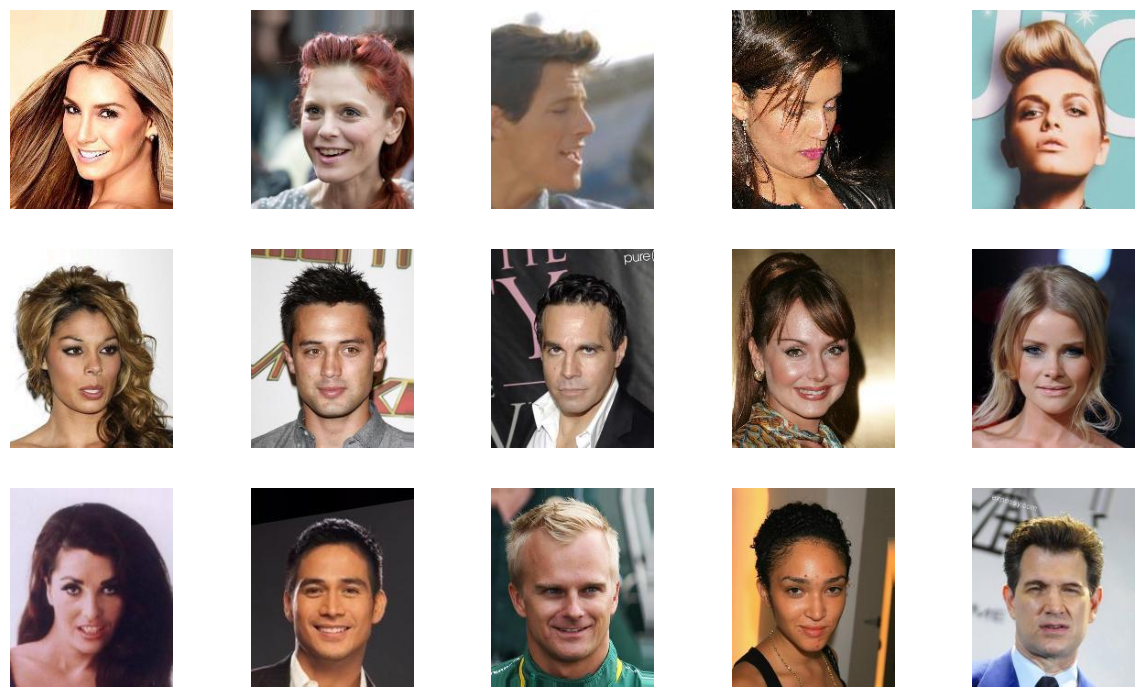

In [9]:
get_images(path='./celebA_train_500/celebA_imgs/', num=15)

In [10]:
PATH_SPLIT = 'celebA_train_500/celebA_train_split.txt'
PATH_IMGS = 'celebA_train_500/celebA_imgs/'
PATH_ANNOTS = 'celebA_train_500/celebA_anno.txt'

RESCALE_SIZE = 384
BATCH_SIZE = 32

with open(PATH_ANNOTS, 'r') as f:
    N_CLASSES = len(set([x.strip().split()[1] for x in f.readlines()]))
EPOCHS = 15
EARLY_STOPPING = 3

In [11]:
def get_paths(path_split: str, path_imgs: str, dataset: str) -> List:
    
    """
    Функция, которая возвращает список из изображений определенного множества
    params:
        path_split: путь, в котором находится разбиение на множества
        path_imgs: путь, в которм находятся изображения
        dataset_type: одно из множеств '0' - train, '1' - test, '2' - val
    """

    with open(path_split, 'r') as f:
        lines = f.readlines()

    lines = [y[0] for y in [x.strip().split() for x in lines] if y[1] == dataset]

    images_paths = []
    for name in lines:            
        images_paths.append(os.path.join(path_imgs, name))
    
    return np.array(images_paths)


def get_labels(path_annots: str, images: List) -> List:
    
    """
    Функция, которая возвращает список из изображений определенного множества
    params:
        path_annots: путь, в котором находится разметка
        images: список изображений из функции get_paths
    """

    with open(path_annots, 'r') as f:
        labels = f.readlines()

    labels = {y:z for y,z in [x.strip().split() for x in labels]}
    labels = [labels[x.split('/')[-1]] for x in images]
    
    return labels
    

class MyDataset(Dataset):
    
    """
    Класс датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    
    def __init__(self, path_split: str=PATH_SPLIT, path_imgs: str=PATH_IMGS, path_annots: str=PATH_ANNOTS, dataset: str='0'):
        super().__init__()
        # список файлов для загрузки
        self.images = get_paths(path_split=path_split, path_imgs=path_imgs, dataset=dataset)
        # список разметки для файлов
        self.labels = get_labels(path_annots=path_annots, images=self.images)
        # режим работы
        dataset_dict = {'0': 'train',
                        '1': 'test',
                        '2': 'val'
                       }
        
        self.mode = dataset_dict[dataset]
    
    def __len__(self):
        # расчет длины
        return len(self.images)

    def load_sample(self, file):
        # загрузка изображения
        try:
            image = Image.open(file)
            return image
        except Exception as ex:
            print(f'Exception -- {ex}')

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == 'train':
            # трансформер для train (добавлена аугментация)
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ColorJitter(brightness=0.4,
                                       contrast=0.3),
                transforms.RandomGrayscale(p=0.2),  
                transforms.GaussianBlur(kernel_size=3),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            # трансформер для valid / test
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])            
        
        img = self.images[index]
        label = int(self.labels[index])

        image = self.load_sample(img)
        image = transform(image)


        return image, label

In [12]:
# Получение datasets и dataloaders

train_dataset = MyDataset(dataset='0')
test_dataset = MyDataset(dataset='1')
val_dataset = MyDataset(dataset='2')
print(len(train_dataset), len(test_dataset), len(val_dataset))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

8544 1878 1589


In [13]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler=None):
    
    """
    Функция, которая требуется на обучении эпохи
    params:
        model: объект модели
        train_loader: обучающий dataloader
        criterion: лосс-функция
        optimizer: оптимизатор
        scheduler: планировщик
    """

    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    if scheduler:
        scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [14]:
def eval_epoch(model, val_loader, criterion):
    
    """
    Функция, которая требуется на валидации эпохи
    params:
        model: объект модели
        val_loader: валидационный dataloader
        criterion: лосс-функция
    """
    
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_data_val = 0

    for inputs, labels in tqdm(val_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data_val += inputs.size(0)
    val_loss = running_loss / processed_data_val
    val_acc = running_corrects.cpu().numpy() / processed_data_val
    return val_loss, val_acc

In [15]:
def fine_train(train_loader, val_loader, model, epochs, criterion, optimizer, scheduler, early_stopping, save=True):
    
    """
    Функция обучения модели
    params:
        train_loader: обучающий dataloader
        val_loader: валидационный dataloader
        model: объект модели
        epochs: количество эпох
        criterion: лосс-функция
        optimizer: оптимизатор
        scheduler: планировщик
        early_stopping: количество шагов для остановки обучения, если валидационная метрика не растет
        save: флаг сохранения модели и истории обучения
    """

    history = []
    best_val = 0
    log_template = """\nEpoch {ep:03d}: 
                      \n* train_loss: {t_loss:0.4f}; val_loss: {v_loss:0.4f}; train_acc: {t_acc:0.4f}; val_acc: {v_acc:0.4f}
                      \n* BEST validation accuracy: {best_loss:0.4f}; Early stopping counter: {early_stop:01d}
                   """

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        
        optimizer = optimizer
        criterion = criterion

        scheduler = scheduler
        stop_counter = 0
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, scheduler)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            if val_acc > best_val:
                best_val = val_acc
                
                best_history_point = {
                    'name': model.name,
                    'optimizer': optimizer,
                    'criterion': criterion,
                    'scheduler': scheduler,
                    'best_model': model,
                    'accuracy': (train_acc, val_acc),
                    'epoch': epoch}
                if save:
                    Path("./model").mkdir(parents=True, exist_ok=True)
                    torch.save(best_history_point, f'./model/best_model_{model.name}.pt')
                stop_counter = 0
            else:
                stop_counter +=1
                
            history.append((train_loss, train_acc, val_loss, val_acc, epoch+1-stop_counter))
            if save:
                Path("./model/history").mkdir(parents=True, exist_ok=True)
                torch.save(history, f'./model/history/history_{model.name}.pt')
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,
                                           v_loss=val_loss, t_acc=train_acc,
                                           v_acc=val_acc, best_loss=best_val,
                                           early_stop=stop_counter
                                          ))
            if stop_counter == early_stopping:
                tqdm.write(f'Stop fine tuning on {epoch+1} epoch with best validation accuracy = {best_val} on {epoch+1-early_stopping} epoch.)')
                break

    return history

In [16]:
def history_plot(history):
    
    """
    Функция отрисовки графиков обучения
    params:
        history: история обучения модели
    """

    train_loss, train_acc, val_loss, val_acc, stop = zip(*history)
    
    fig, ax = plt.subplots(1,2, figsize=(20, 6))
    ax[0].plot(train_loss, label=f"Train loss",color='blue')
    ax[0].plot(val_loss, label=f"Validation loss",color='orange')
    ax[0].axvline(stop[-1], color='green', linestyle=':')
    ax[0].legend(loc='upper right', fontsize='xx-small')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel("loss")

    ax[1].plot(train_acc, label=f"Train accuracy",color='blue')
    ax[1].plot(val_acc, label=f"Validation accuracy",color='orange')
    ax[1].axvline(stop[-1], color='green', linestyle=':')
    ax[1].legend(loc='upper right', fontsize='x-small')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel("scores")
    
    fig.suptitle(f"History of training")

    plt.show()

In [17]:
# импортирование предобученной модели

from torchvision.models import efficientnet_b2 #, resnet50
model = efficientnet_b2(pretrained=True)
model

C:\Users\admin\anaconda3\envs\hair\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\admin\anaconda3\envs\hair\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [18]:
# замена последнего слоя предобученной модели

#in_features = model.fc.in_features
in_features = 1408

model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features=in_features, out_features=N_CLASSES*2, bias=True),
    nn.BatchNorm1d(N_CLASSES*2),
    nn.Dropout(0.2),
    nn.Linear(in_features=N_CLASSES*2, out_features=N_CLASSES, bias=True)
)

base_model = copy.deepcopy(model).to(DEVICE)

# Пропишем название модели
base_model.name = 'BaseEfficientNetB2'

print("We will classify :{}".format(N_CLASSES))
print(base_model)

We will classify :500
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          

In [19]:
# оптимизатор, лосс-функция и планировщик для нашей модели

opt = torch.optim.AdamW(base_model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
scheduler_opt = torch.optim.lr_scheduler.StepLR(opt, step_size=3, gamma=0.5)

In [20]:
# обучение модели

history = fine_train(train_loader=train_loader,
                     val_loader=val_loader,
                     model=base_model,
                     epochs=EPOCHS,
                     criterion=loss_fn,
                     optimizer=opt,
                     scheduler=scheduler_opt,
                     early_stopping=EARLY_STOPPING
                    )

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 001: 
                      
* train_loss: 5.1615; val_loss: 3.7233; train_acc: 0.0758; val_acc: 0.2215
                      
* BEST validation accuracy: 0.2215; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 002: 
                      
* train_loss: 2.9996; val_loss: 2.4407; train_acc: 0.3209; val_acc: 0.4374
                      
* BEST validation accuracy: 0.4374; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 003: 
                      
* train_loss: 1.7302; val_loss: 1.8954; train_acc: 0.5750; val_acc: 0.5588
                      
* BEST validation accuracy: 0.5588; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 004: 
                      
* train_loss: 0.6287; val_loss: 1.1115; train_acc: 0.8502; val_acc: 0.7514
                      
* BEST validation accuracy: 0.7514; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 005: 
                      
* train_loss: 0.2635; val_loss: 1.0761; train_acc: 0.9443; val_acc: 0.7640
                      
* BEST validation accuracy: 0.7640; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 006: 
                      
* train_loss: 0.1454; val_loss: 1.0536; train_acc: 0.9739; val_acc: 0.7678
                      
* BEST validation accuracy: 0.7678; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 007: 
                      
* train_loss: 0.0631; val_loss: 0.9157; train_acc: 0.9940; val_acc: 0.8037
                      
* BEST validation accuracy: 0.8037; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 008: 
                      
* train_loss: 0.0411; val_loss: 0.9111; train_acc: 0.9958; val_acc: 0.8068
                      
* BEST validation accuracy: 0.8068; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 009: 
                      
* train_loss: 0.0301; val_loss: 0.8980; train_acc: 0.9977; val_acc: 0.8005
                      
* BEST validation accuracy: 0.8068; Early stopping counter: 1
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 010: 
                      
* train_loss: 0.0213; val_loss: 0.8770; train_acc: 0.9989; val_acc: 0.8169
                      
* BEST validation accuracy: 0.8169; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 011: 
                      
* train_loss: 0.0195; val_loss: 0.8643; train_acc: 0.9986; val_acc: 0.8169
                      
* BEST validation accuracy: 0.8169; Early stopping counter: 1
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 012: 
                      
* train_loss: 0.0163; val_loss: 0.8583; train_acc: 0.9996; val_acc: 0.8219
                      
* BEST validation accuracy: 0.8219; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 013: 
                      
* train_loss: 0.0136; val_loss: 0.8569; train_acc: 0.9996; val_acc: 0.8219
                      
* BEST validation accuracy: 0.8219; Early stopping counter: 1
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 014: 
                      
* train_loss: 0.0129; val_loss: 0.8488; train_acc: 0.9996; val_acc: 0.8257
                      
* BEST validation accuracy: 0.8257; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 015: 
                      
* train_loss: 0.0120; val_loss: 0.8518; train_acc: 0.9994; val_acc: 0.8244
                      
* BEST validation accuracy: 0.8257; Early stopping counter: 1
                   


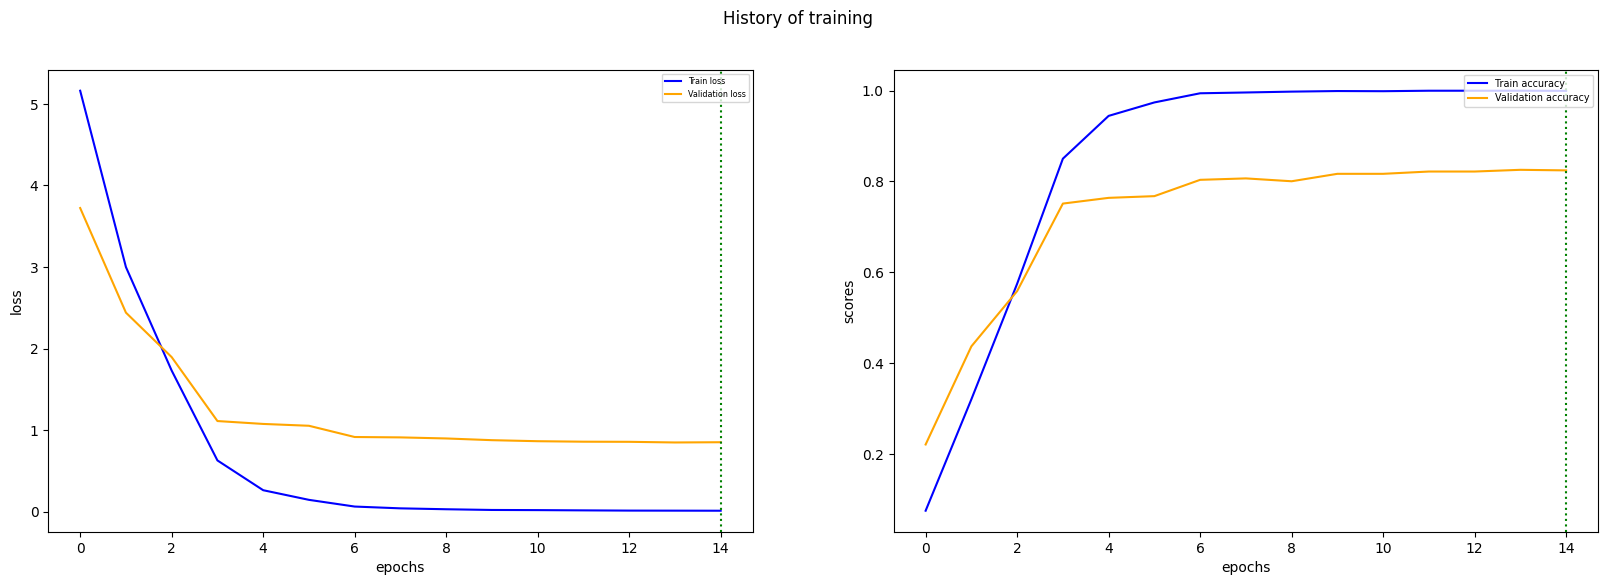

In [21]:
history = torch.load(f'./model/history/history_{base_model.name}.pt')
history_plot(history)

In [22]:
history_point = torch.load(f'./model/best_model_{base_model.name}.pt', map_location=DEVICE)
history_point

{'name': 'BaseEfficientNetB2',
 'optimizer': AdamW (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     initial_lr: 0.001
     lr: 6.25e-05
     maximize: False
     weight_decay: 0.01
 ),
 'criterion': CrossEntropyLoss(),
 'scheduler': <torch.optim.lr_scheduler.StepLR at 0x1c032c1a6d0>,
 'best_model': EfficientNet(
   (features): Sequential(
     (0): Conv2dNormActivation(
       (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): SiLU(inplace=True)
     )
     (1): Sequential(
       (0): MBConv(
         (block): Sequential(
           (0): Conv2dNormActivation(
             (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
             (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=T

In [23]:
base_model_best = history_point['best_model']

In [24]:
# проверка модели на тестовом множестве

_, test_accuracy = eval_epoch(model=base_model_best,
                              val_loader=test_loader,
                              criterion=loss_fn)
test_accuracy

  0%|          | 0/59 [00:00<?, ?it/s]

0.8242811501597445

In [25]:
test_accuracy_dict = dict()
test_accuracy_dict['CELoss_base_model'] = test_accuracy

### Cosine similarity calculation - расчет косинусного расстояния между эмбеддингами лиц знаменитых людей

In [26]:
# копирование лучшей модели и удаление из нее последнего слоя классификатора

emb_model = copy.deepcopy(base_model_best)
del emb_model.classifier[-1]

base_model_best.classifier, emb_model.classifier

(Sequential(
   (0): Dropout(p=0.3, inplace=False)
   (1): Linear(in_features=1408, out_features=1000, bias=True)
   (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (3): Dropout(p=0.2, inplace=False)
   (4): Linear(in_features=1000, out_features=500, bias=True)
 ),
 Sequential(
   (0): Dropout(p=0.3, inplace=False)
   (1): Linear(in_features=1408, out_features=1000, bias=True)
   (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (3): Dropout(p=0.2, inplace=False)
 ))

In [27]:
def get_photos_tensor(dataset, number):
    
    """
    Функция отрисовки графиков обучения
    params:
        dataset: датасет
        number: номер знаменитости
    """
    
    transform = transforms.Compose([
    transforms.ToTensor(),
#    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]) 
    
    photos = []
    for i, j in enumerate(dataset.labels):
        if int(j) == number:
            photos.append(dataset.images[i])
            
    if len(photos) != 0:
        photos = torch.stack([transform(Image.open(x)) for x in photos])
    else:
        photos = torch.Tensor()
        
    return photos

In [28]:
# применение модели на определенных фото знаменитостей и расчет косинусной близости между эмбеддингами

emb_model.eval()
with torch.no_grad():
    person_train_50 = emb_model(get_photos_tensor(train_dataset, 50).to(DEVICE))
    person_test_50 = emb_model(get_photos_tensor(test_dataset, 50).to(DEVICE))

    person_test_100 = emb_model(get_photos_tensor(test_dataset, 100).to(DEVICE))

cosine_similarity(person_train_50.cpu(), person_test_50.cpu()).mean(), cosine_similarity(person_train_50.cpu(), person_test_100.cpu()).mean()

(0.5657121, 0.31918946)

In [29]:
F.cosine_similarity(person_train_50.cpu()[0], person_test_50.cpu()[0], dim=0)

tensor(0.7185)

In [30]:
F.cosine_similarity(person_train_50.cpu()[0], person_test_100.cpu()[0], dim=0)

tensor(0.5189)

**Вывод:**
* Видно, что у эмбеддингов лиц одного человека косинусное расстояние ближе, чем у эмбеддингов лиц разных людей! **Отлично,** значит модель их хорошо разделяет

---

## 2. Identification Rate Metric (2 балла) 
*  Реализовать Identification Rate Metric (ниже дан щаблон кода для него и ячейки для тестирования)

## Шаблон кода для Identificaton rate metric (TPR@FPR)

**Данные**. Если вы обучали нейросеть для распознавания лиц на данных, предложенных в этом ноутбуке (CelebA-500), то для подсчета метрики вы можете воспользоваться данными, которые лежат по этой ссылке: https://disk.yandex.com/d/KN4EEkNKrF_ZXQ. Эти данные уже разбиты на query и distractors, и в отдельном файле также находится информация о классах для картинок из query. Эти картинки заалайнены точно так же, как картинки из обучающей выборки CelebA-500

Если вы обучали нейросеть на других данных, то вам нужно сделать данные для тестирования самому. Делается это примерно так:
- Выбраете несколько id, которые не использовались при тренировке моделей, и помещаете их в query set;
- Выбираете несколько id, которые не использовались при тренировке моделей и не входят в query, и помещаете их в distractors set. Обычно distractors set должен быть сильно больше, чем query set.
- Обрабатываете картинки из query и distractors тем же способом, что картинки для обучения сети.


Обратите внимание, что если картинок в query и distractors очень много, то полученных пар картинок в пунктах 1-2-3 алгоритма подсчета TPR@FPR будет очень-очень много. Чтобы код подсчета работал быстрее, ограничивайте размеры этих датасетов. Контролируйте, сколько значений расстояний вы считаете.

Ниже дан шаблон кода для реализации FPR@TPR метрики и ячейки с тестами. Тесты проверяют, что ваш код в ячейках написан правильно.

**Identification rate**. Вот как она работает:

Создадим два набора изображений лиц: query и distractors. Никакие лица из этих наборов не должны содержаться в обучающем и валидационном датасете.

1. посчитаем косинусные расстояния между лицами, соответствующими одним и тем же людям из query части. Например, пусть одному человеку соответствуют три фото в query: 01.jpg, 02.jpg, 03.jpg. Тогда считаем три косинусных расстояния между всеми тремя парами из этих фото.
2. посчитаем косинусные расстояния между лицами, соответствующими разным людям из query части.
3. посчитаем косинусные расстояния между всеми парами лиц из query и distractors. Т.е. пара — это (лицо из query, лицо из distractors). Всего получится |query|*|distractors| пар.
4. Сложим количества пар, полученных на 2 и 3 шагах. Это количество false пар.
5. Зафиксируем **FPR** (false positive rate). Пусть, например, будет 0.01. FPR, умноженный на количество false пар из шага 4 — это разрешенное количество false positives, которые мы разрешаем нашей модели. Обозначим это количество через N.
6. Отсортируем все значения косинусных расстояний false пар. N — ое по счету значение расстояния зафиксируем как **пороговое расстояние**.
7. Посчитаем количество positive пар с шага 1, которые имеют косинусное расстояние меньше, чем пороговое расстояние. Поделим это количество на общее количество positive пар с шага 1. Это будет TPR (true positive rate) — итоговое значение нашей метрики.

Такая метрика обычно обозначается как TPR@FPR=0.01. FPR может быть разным. Приразных FPR будет получаться разное TPR.

Смысл этой метрики в том, что мы фиксируем вероятность ошибки вида false positive, т.е. когда "сеть сказала, что это один и тот же человек, но это не так", считаем порог косинусного расстояния для этого значения ошибки, потом берем все positive пары и смотрим, у скольких из них расстояние меньше этого порога. Т.е. насколько точно наша сеть ищет похожие лица при заданной вероятности ошибки вида false positive.

In [31]:
# Если вы работаете с данными, которые даны по ссылке,
# то эта ячейка поможет их загрузить
from collections import defaultdict

# file with query part annotations: which image belongs to which class
# format:
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('./celebA_ir/celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = [x[0] for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
    query_dict[img_class].append(img_name)

# list of distractor images
distractors_img_names = os.listdir('./celebA_ir/celebA_distractors')

In [32]:
print(len(query_img_names),len(query_dict),len(distractors_img_names))

1222 51 2001


In [33]:
class MyDatasetIr(Dataset):
    
    """
    Класс датасет для расчета Identification Rate
    """
    
    def __init__(self, images_list: List):
        self.images = images_list
        self.transform = transforms.Compose([
            transforms.ToTensor(),
#            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])   

    def __len__(self):
        return len(self.images)

    def load_sample(self, file):
        try:
            image = Image.open(file)
            return image
        except Exception as ex:
            print(f'Exception -- {ex}')

    def get_tensors(self):
        images = torch.stack([self.transform(Image.open(f'{self.images_path}/{img_name}')) for img_name in self.images])
        return images

    def __getitem__(self, index): 
        
        img = self.images[index]
        
        image = self.load_sample(img)
        image = self.transform(image)

        return image, index

In [34]:
PATH_IMGAGES_QUERY = 'celebA_ir/celebA_query'
PATH_IMGAGES_DISTRACTORS = 'celebA_ir/celebA_distractors'

In [35]:
def compute_embeddings(model, images_list: List, images_path: str):
    
    """
    Функция расчета эмбеддингов фото
    params:
        model: объект модели
        images_list: список фото
        images_path: путь расположения фото
    """

    model.to(DEVICE)
    dataset = MyDatasetIr(images_list)
    tensors = torch.stack([dataset.transform(Image.open(f'{images_path}/{img_name}')) for img_name in dataset.images])
    dataloader = DataLoader(tensors, batch_size=BATCH_SIZE, shuffle=False)

    model.eval()
    with torch.no_grad():
        embeddings_list = []
        for input in tqdm(dataloader):
            embedding = model(input.to(DEVICE))
            embeddings_list.append(embedding.detach().cpu())
            del input
            
    return torch.cat(embeddings_list).numpy()

In [36]:
# получаем эмбеддинги

distractors_embeddings = compute_embeddings(model=emb_model, images_list=distractors_img_names, images_path=PATH_IMGAGES_DISTRACTORS)# расчитываем эмбеддинги для query_img_names и 

query_embeddings = compute_embeddings(model=emb_model, images_list=query_img_names, images_path=PATH_IMGAGES_QUERY)
distractors_embeddings = compute_embeddings(model=emb_model, images_list=distractors_img_names, images_path=PATH_IMGAGES_DISTRACTORS)

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

In [37]:
def comb(s):
    
    """
    Функция создания комбинаций объектов
    params:
        s: объект
    """
    
    for i, v1 in enumerate(s):
        for j in range(i+1, len(s)):
            yield [v1, s[j]]

def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
    
    """
    Функция расчета косинусной близости для положительных объектов (одни и те же лица)
        query_dict: словать запросов
        query_img_names: список наименований фото лиц
        query_embeddings: эмбеддинги фото лиц
    """
    
    results_list = []
    with torch.no_grad():
        for label, images in tqdm(query_dict.items()):
            
            if len(images) > 1:
                images_pair = comb(images)
                for imgs in images_pair:
                    f_embedding = torch.Tensor(query_embeddings[query_img_names.index(imgs[0])])
                    s_embeding = torch.Tensor(query_embeddings[query_img_names.index(imgs[1])])

                    cosine_dist = F.cosine_similarity(f_embedding, s_embeding, dim=0)
                    results_list.append(cosine_dist)
    return results_list


def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
    
    """
    Функция расчета косинусной близости для отрицательных объектов (разные лица)
        query_dict: словать запросов
        query_img_names: список наименований фото лиц
        query_embeddings: эмбеддинги фото лиц
    """
    
    results_list = []
    query_dict_keys = list(query_dict.keys())
    pairs = np.array([(i, j) for i in query_dict_keys for j in query_dict_keys])

    for pair in tqdm(pairs):
        if ((pair[0] < pair[1]) and (pair[0] != pair[1])):
            images_pair = np.array([(i, j) for i in query_dict[pair[0]] for j in query_dict[pair[1]]])
            for imgs in images_pair:
                f_embedding = torch.Tensor(query_embeddings[query_img_names.index(imgs[0])])
                s_embeding = torch.Tensor(query_embeddings[query_img_names.index(imgs[1])])
                
                cosine_dist = F.cosine_similarity(f_embedding, s_embeding, dim=0)
                results_list.append(cosine_dist)
    return results_list

In [38]:
def compute_cosine_query_distractors(query_embeddings: list, distractors_embeddings: list) -> list:
    
    """
    Функция расчета косинусной близости эмбеддингов query и distractors
        query_embeddings: эмбеддинги фото лиц query
        distractors_embeddings: эмбеддинги фото лиц distractors
    """

    result_list = []
    pairs = np.array([(i, j) for i in query_embeddings for j in distractors_embeddings])
    for pair in tqdm(pairs):
        f_embedding = torch.Tensor(pair[0])
        s_embeding = torch.Tensor(pair[1])
        cosine_dist = F.cosine_similarity(f_embedding, s_embeding, dim=0)
        result_list.append(cosine_dist)
        
    return result_list

In [39]:
# расчет косинусных расстояний

cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings,
                                                            distractors_embeddings)


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/2601 [00:00<?, ?it/s]

  0%|          | 0/2445222 [00:00<?, ?it/s]

Ячейка ниже проверяет, что код работает верно:

In [40]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,
                                                            test_distractors_embeddings)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [41]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

И, наконец, финальная функция, которая считает IR metric:

In [42]:
def compute_ir(cosine_query_pos: List, cosine_query_neg: List, cosine_query_distractors: List, fpr: float=0.1):
    
    """
    Функция расчета Identification Rate
        cosine_query_pos: косинусные расстояния по одним и тем же лицам из query 
        cosine_query_neg: косинусные расстояния по разным лицам из query 
        cosine_query_distractors: косинусные расстояния между query и distractors
        fpr: false positive rate
    """

    cosine_query_pos = torch.Tensor(cosine_query_pos)
    cosine_query_neg = torch.Tensor(cosine_query_neg)
    cosine_query_distractors = torch.Tensor(cosine_query_distractors)
    
    false_pairs = torch.sort(torch.cat((cosine_query_neg, cosine_query_distractors)), descending=True)[0]
    false_pos_thr = int(fpr * len(false_pairs))
    threshold = false_pairs[false_pos_thr]
    tpr = len(cosine_query_pos[cosine_query_pos >= threshold]) / len(cosine_query_pos)

    return threshold.item(), tpr

И ячейки для ее проверки:

In [43]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
    x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg,
                      test_cosine_query_distractors, fpr=fpr)
    test_thr.append(x)
    test_tpr.append(y)

In [44]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

А в ячейке ниже вы можете посчитать TPR@FPR для датасета с лицами. Давайте, например, посчитаем для значений fpr = [0.5, 0.2, 0.1, 0.05].

In [45]:
# расчет tpr@frp для наших эмбеддингов

face_thr = []
face_tpr = []
face_fpr = [0.5, 0.2, 0.1, 0.05]
for fpr in tqdm(face_fpr):
    x, y = compute_ir(cosine_query_pos, cosine_query_neg, 
                    cosine_query_distractors, fpr=fpr)
    face_thr.append(x)
    face_tpr.append(y)
    
print(face_thr)
print(face_tpr)

  0%|          | 0/4 [00:00<?, ?it/s]

[0.5821470022201538, 0.6814225912094116, 0.7269500494003296, 0.7608899474143982]
[0.7778004211670403, 0.5142993003192717, 0.3689287412539909, 0.2606480538006929]


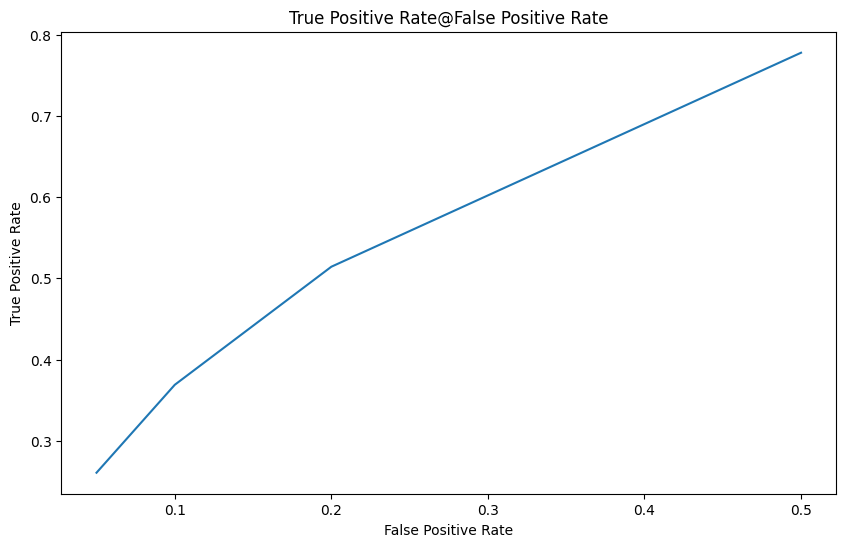

In [46]:
# отрисовка tpr@fpr

plt.figure(figsize=(10, 6))
plt.plot(face_fpr, face_tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('True Positive Rate@False Positive Rate')
plt.show()

---

## 3. ArcFace loss (2 балла) 
*  Реализовать ArcFace loss, обучить сеть с нуля на нем. Добиться accuracy на тестовой части >0.7

#### ArcFace Loss (Additive Angular Margin Loss)

В случае с обучением на задачу классификации лосс-функция, которая нам приходит в голову — Cross-Entropy. И на нее действительно можно обучать сеть для распознавания лиц. Но за много лет люди придумали более хитрые лосс-функции, которые делают обучение сети для распознавания лиц более эффективным. Одним из лучших считается ArcFace Loss (Additive Angular Margin Loss).

Этот лосс — чуть измененная кросс-энтропия. Он позволяет достичь лучшего распределения векторов лиц на сфере. В нем добавлены некоторые дополнительные ограничения и гиперпараметры, для того чтобы эмбеддинги лиц одного класса были более близки между собой, а эмбеддинги лиц разных людей оставались далеки. То есть, этот лосс позволяет лучше кластеризовать лица на сфере единичного радиуса.

**Как устроен ArcFace**:

Стандартные SoftMax + кросс-энтропия (CE) выглядят так:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

здесь:
- $x_i \in \mathbb{R^d}$ — вектор $i$-го элемента обучающей выборки перед последним полносвязным слоем сети. $y_i$ — класс этого элемента;
- $W_j \in \mathbb{R^d}$ — j-ый столбец матрицы весов последнего слоя сети (т.е. слоя, который производит итоговую классификацю входящего объекта);
- $b_j \in \mathbb{R^d}$ — j-ый элемент вектора байеса последнего слоя сети;
- $N$ — batch size;
- $n$ — количество классов.


Хотя этот лосс работает хорошо, он явным образом не заставляет эмбеддинги $x_i$ элементов, принадлежащих одному классу, быть близкими друг к другу по расстоянию. И не заставляет эмбеддинги элементов, принадлежащих разным классам, быть далеко друг от друга. Все, что хочет этот лосс — чтобы на основе эмбеддингов $x_i$ можно было хорошо классифицировать элементы, никакие ограничений на расстояния между эмбеддингами $x_i$ он не вводит.

Из-за этого у нейросетей для распознавания лиц, которые обучены на обычном CE loss, бывают проблемы с распознаванием лиц, которые сильно отличаются от лиц того же человека разными допатрибутами (шляпа/прическа/очки и т.п.). Просто эмбеддинг для таких лиц получается довольно далек по расстоянию от других эмбеддингов лиц этого же человека.

Давайте теперь немного поправим формулу:
- уберем байес последнего слоя, т.е. сделаем $b_j=0$;
- нормализуем веса последнего слоя: ||$W_j$|| = 1;
- нормализуем эмбеддинги: ||$x_i$|| = 1. Перед подачей их на вход последнему слою (т.е. перед умножением на матрицу $W_j$) умножим их на гиперпараметр s. По сути, мы приводим норму всех эмбеддингов к s. Смысл этого гиперпараметра в том, что, возможно, сети проще будет классифицировать эмбеддинги, у которых не единичная норма.

Нормализация эмбеддингов приводит к тому, что эмбеддинги начинают быть распределены по сфере единичного радиуса (и сфере радиуса s после умножения на ниперпараметр s). И итоговые предсказания сети после последнего слоя зависят только от угла между эмбеддингами $x_i$ и выученных весов $W_j$. От нормы эмбеддинга $x_i$ они больше не зависят, т.к. у всех эмбеддингов они теперь одинаковые.

Получается, в степени экспоненты у нас останется выражение $s W_{y_i}^{T}x_i$, которое можно переписать в виде  $s W_{y_i}^{T}x_i = s ||W_{y_i}||\cdot ||x_i|| \cdot cos\Theta_{y_i}$. Тут $\Theta_{y_i}$ — это угод между векторами $W_{y_i}$ и $x_i$. Но так как мы сделали нормы $W_{y_i}$ и $x_i$ единичными, то все это выражение просто будет равно $s cos\Theta_{y_i}$.

В итоге мы получим следующую формулу лосса:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$


И последний шаг. Добавим еще один гиперпараметр $m$. Он называется additive angular margin penalty и заставляет эмбеддинги одного класса быть ближе друг к другу, а эмбеддинги разных классов — более далекими друг от друга.

В итоге получим вот что:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Это и есть ArcFace Loss с двумя  гиперпараметрами, s и m.

Получается, что ArcFace Loss завтавляет сеть выучивать эмбеддинги, распределенные по сфере радиуса s, причем чтобы эмбеддинги одного класса были ближе друг к другу, а эмбеддинги разных классов — более далеки друг от друга.

**Доплитература по ArcFace Loss:**

Оригинальная статья: https://arxiv.org/pdf/1801.07698.pdf

Репозиторий с кодом: https://github.com/deepinsight/insightface

In [47]:
class ArcFaceLoss(nn.Module):
    
    """
    Класс ArcFace лосс-функции
    """
    
    def __init__(self, embedding_size, num_classes, margin=0.5, scale=64, eps=1e-6):
        super(ArcFaceLoss, self).__init__()
        
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        self.margin = margin
        self.scale = scale
        self.eps = eps
        self.W = nn.Parameter(torch.Tensor(num_classes, embedding_size))
        nn.init.xavier_normal_(self.W)

        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.theta = math.cos(math.pi - margin)
        self.sinmm = math.sin(math.pi - margin) * margin


    def _get_cosine(self, embeddings):
        normalized_embeddings = F.normalize(embeddings)
        normalized_W = F.normalize(self.W)
        cosine = F.linear(normalized_embeddings, normalized_W)

        return cosine

    def forward(self, embeddings, labels):
        cosine = self._get_cosine(embeddings)
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m   
        phi = torch.where(cosine > self.theta, phi, cosine - self.sinmm)
            
        onehot = torch.zeros_like(cosine)
        onehot.scatter_(1, labels.unsqueeze(-1), 1)
        onehot = (1 - self.eps) * onehot + self.eps / self.num_classes

        logits = (onehot * phi) + ((1.0 - onehot) * cosine)
        logits = self.scale * logits

        return logits

In [48]:
class ArcFaceModel(nn.Module):
    
    """
    Класс ArcFace модели - добавление бачнорма и ArcFace лосс-функции как последние слои предобученной модели
    """
    
    def __init__(self, pretrained_model, embedding_size, num_classes):
        super(ArcFaceModel, self).__init__()

        self.premodel = copy.deepcopy(pretrained_model)
        self.bachnorm = nn.BatchNorm1d(embedding_size)
        self.arcface = ArcFaceLoss(embedding_size=embedding_size, num_classes=num_classes)

    def forward(self, x, labels=None):
        x = self.premodel(x)
        x = self.bachnorm(x)
        if labels is not None:
            x = self.arcface(x, labels)
        return x

In [49]:
arcface_model = ArcFaceModel(pretrained_model=efficientnet_b2(pretrained=True),
                             embedding_size=1000, 
                             num_classes=N_CLASSES
                            ).to(DEVICE)

arcface_model.name = 'ArcFaceModel'
arcface_model

C:\Users\admin\anaconda3\envs\hair\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\admin\anaconda3\envs\hair\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ArcFaceModel(
  (premodel): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale

In [50]:
opt = torch.optim.AdamW(arcface_model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
scheduler_opt = torch.optim.lr_scheduler.StepLR(opt, step_size=3, gamma=0.5)

In [51]:
history = fine_train(train_loader=train_loader,
                     val_loader=val_loader, 
                     model=arcface_model, 
                     epochs=EPOCHS,
                     optimizer=opt,
                     criterion=loss_fn,
                     scheduler=scheduler_opt,
                     early_stopping=EARLY_STOPPING
                     )

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 001: 
                      
* train_loss: 5.9441; val_loss: 4.7620; train_acc: 0.0619; val_acc: 0.2222
                      
* BEST validation accuracy: 0.2222; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 002: 
                      
* train_loss: 4.3369; val_loss: 3.3667; train_acc: 0.2705; val_acc: 0.4028
                      
* BEST validation accuracy: 0.4028; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 003: 
                      
* train_loss: 3.4331; val_loss: 2.3310; train_acc: 0.4648; val_acc: 0.5582
                      
* BEST validation accuracy: 0.5582; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 004: 
                      
* train_loss: 2.6717; val_loss: 1.5535; train_acc: 0.6836; val_acc: 0.7168
                      
* BEST validation accuracy: 0.7168; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 005: 
                      
* train_loss: 2.2764; val_loss: 1.4024; train_acc: 0.7879; val_acc: 0.7262
                      
* BEST validation accuracy: 0.7262; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 006: 
                      
* train_loss: 2.0031; val_loss: 1.2335; train_acc: 0.8493; val_acc: 0.7533
                      
* BEST validation accuracy: 0.7533; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 007: 
                      
* train_loss: 1.7501; val_loss: 0.9996; train_acc: 0.9045; val_acc: 0.7961
                      
* BEST validation accuracy: 0.7961; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 008: 
                      
* train_loss: 1.6072; val_loss: 0.9831; train_acc: 0.9313; val_acc: 0.8131
                      
* BEST validation accuracy: 0.8131; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 009: 
                      
* train_loss: 1.5010; val_loss: 0.9840; train_acc: 0.9460; val_acc: 0.8081
                      
* BEST validation accuracy: 0.8131; Early stopping counter: 1
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 010: 
                      
* train_loss: 1.4019; val_loss: 0.9113; train_acc: 0.9568; val_acc: 0.8232
                      
* BEST validation accuracy: 0.8232; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 011: 
                      
* train_loss: 1.3411; val_loss: 0.8950; train_acc: 0.9621; val_acc: 0.8307
                      
* BEST validation accuracy: 0.8307; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 012: 
                      
* train_loss: 1.2849; val_loss: 0.8761; train_acc: 0.9699; val_acc: 0.8339
                      
* BEST validation accuracy: 0.8339; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 013: 
                      
* train_loss: 1.2594; val_loss: 0.8841; train_acc: 0.9696; val_acc: 0.8326
                      
* BEST validation accuracy: 0.8339; Early stopping counter: 1
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 014: 
                      
* train_loss: 1.2251; val_loss: 0.8750; train_acc: 0.9702; val_acc: 0.8420
                      
* BEST validation accuracy: 0.8420; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 015: 
                      
* train_loss: 1.2012; val_loss: 0.8786; train_acc: 0.9720; val_acc: 0.8313
                      
* BEST validation accuracy: 0.8420; Early stopping counter: 1
                   


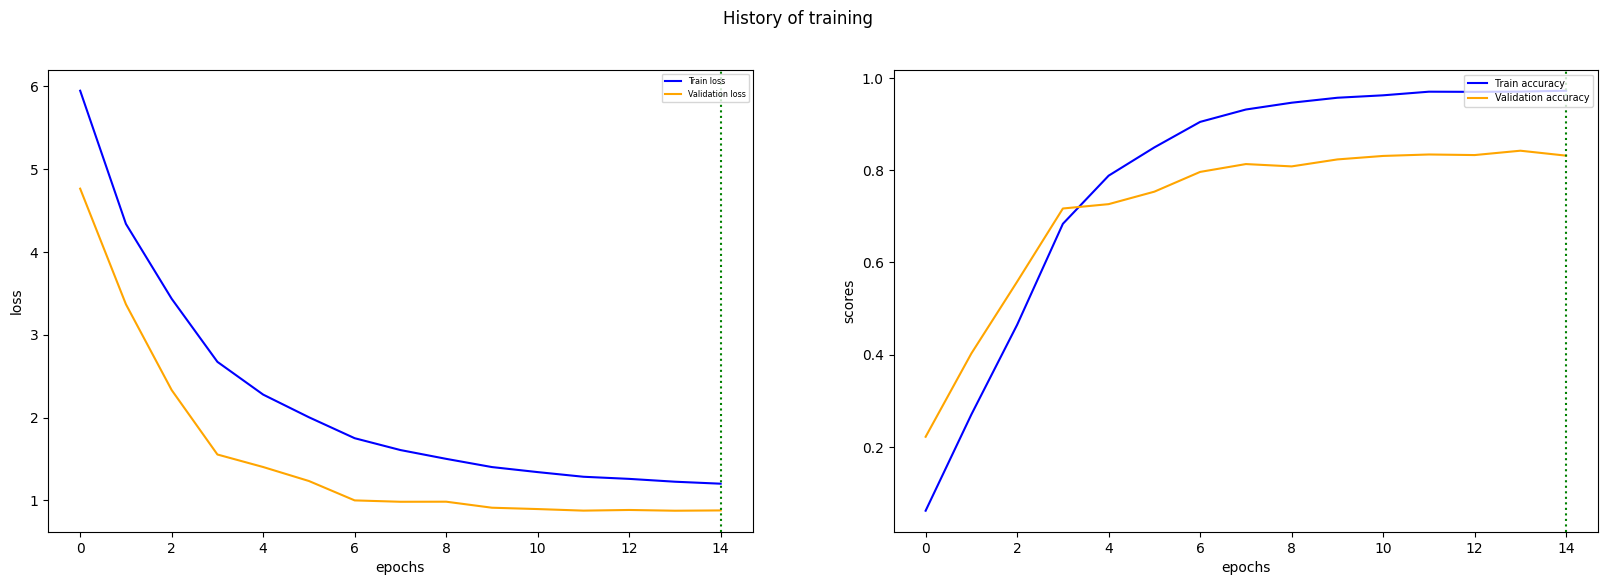

In [52]:
history = torch.load(f'./model/history/history_{arcface_model.name}.pt')
history_plot(history)

In [53]:
arcface_model_best = torch.load(f'./model/best_model_{arcface_model.name}.pt', map_location=DEVICE)['best_model']
arcface_model_best

ArcFaceModel(
  (premodel): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale

In [54]:
_, test_accuracy = eval_epoch(model=arcface_model_best,
                              val_loader=test_loader,
                              criterion=loss_fn)
test_accuracy

  0%|          | 0/59 [00:00<?, ?it/s]

0.8370607028753994

In [55]:
test_accuracy_dict['ArcFaceLoss_model'] = test_accuracy

---

## 4. Исследовать пространство полученных эмбеддингов (2 балла) 

* Например, как в случае Arcface Loss расположены эмбеддинги на сфере? Где расположены эмбеддинги картинок-аутлаеров? (например, если лицо на картинке сильно смазано или почти не видно. Или это вообще не картинка лица). Как еще можно исследовать модель?

In [56]:
def get_arcface_embeddings(data_loader, model):
    
    """
    Функция вычисления эмбеддингов из модели
        data_loader: получаемый dataloader
        model: объект модели
    """
    
    model.eval()
    
    embeddings_list, labels_list = list(), list()
    
    for inputs, labels in tqdm(data_loader):
        labels_list.append(labels)
        inputs = inputs.to(DEVICE)

        with torch.no_grad():
            outputs = model(inputs)
            embeddings_list.append(outputs)

    embeddings_list = torch.squeeze(torch.cat(embeddings_list, dim=0).cpu())
    labels_list = torch.cat(labels_list).cpu()

    return embeddings_list, labels_list

In [57]:
# получим эмбеддинги и лейблы

train_embeddings, train_labels = get_arcface_embeddings(data_loader=train_loader,
                                                        model=arcface_model_best)

val_embeddings, val_labels = get_arcface_embeddings(data_loader=val_loader,
                                                    model=arcface_model_best)

test_embeddings, test_labels = get_arcface_embeddings(data_loader=test_loader,
                                                      model=arcface_model_best)

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

* **Давайте** посмотрим, как латентные векторы картинок лиц выглядят в пространстве. Изобразим векторы картинок точками в двумерном просторанстве. Это позволит оценить, насколько плотно распределены латентные векторы изображений в пространстве.

* Также **покрасим** точки, которые соответствуют картинкам каждого лица, в свой отдельный цвет

    * С помощтю **TSNE**  сожмем эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве). Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам разных цифр.

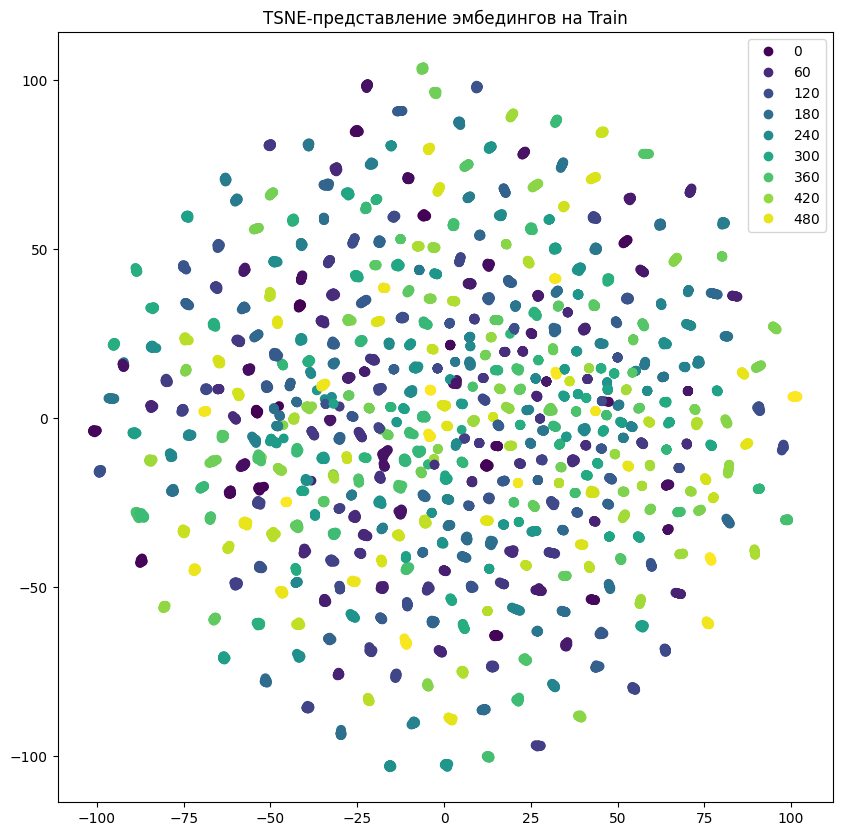

In [58]:
tsne_model = TSNE(n_components=2)
tsne_res = tsne_model.fit_transform(train_embeddings)

fig = plt.figure( figsize=(10,10) )
ax = fig.add_subplot(1, 1, 1, title='TSNE-представление эмбедингов на Train')
scatter = ax.scatter(x=tsne_res[:,0], y=tsne_res[:,1], c=train_labels)
ax.legend(*scatter.legend_elements())
plt.show()

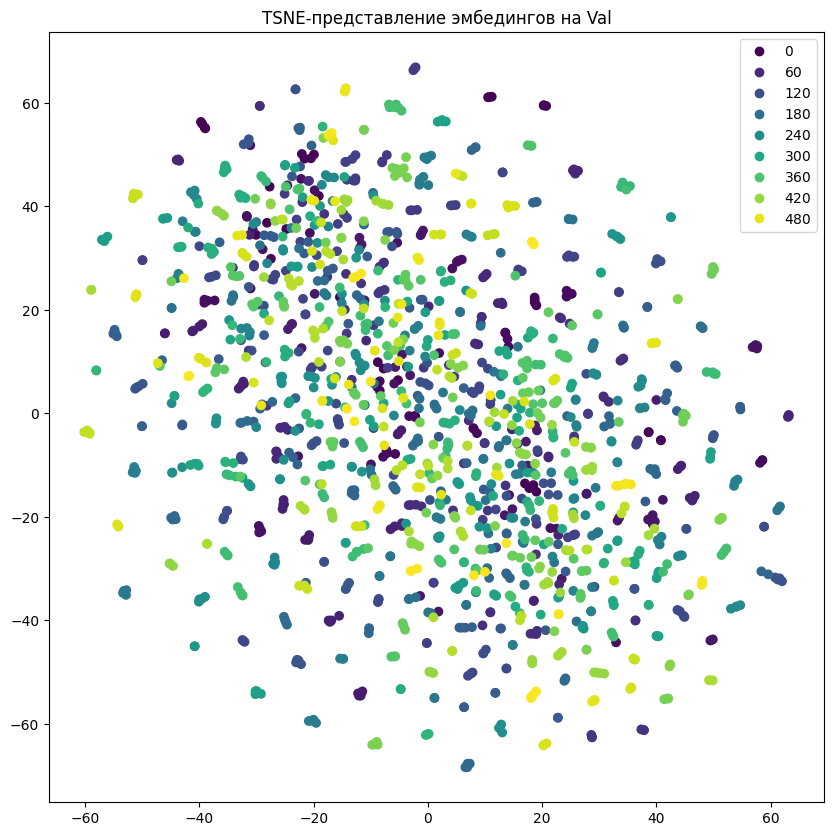

In [59]:
tsne_model = TSNE(n_components=2)
tsne_res = tsne_model.fit_transform(val_embeddings)

fig = plt.figure( figsize=(10,10) )
ax = fig.add_subplot(1, 1, 1, title='TSNE-представление эмбедингов на Val')
scatter = ax.scatter(x=tsne_res[:,0], y=tsne_res[:,1], c=val_labels)
ax.legend(*scatter.legend_elements())
plt.show()

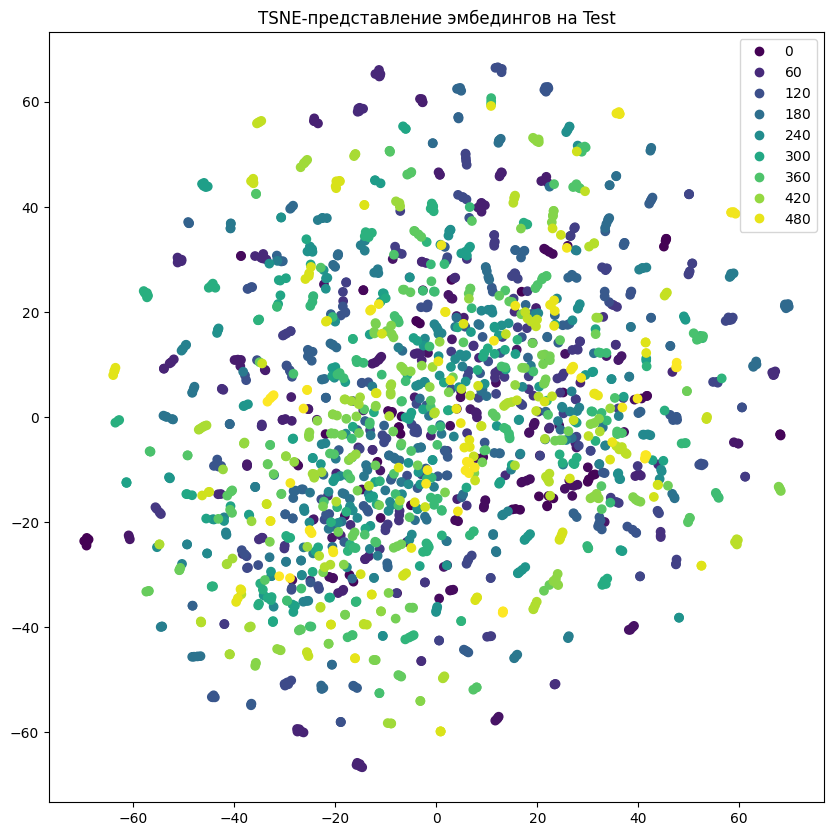

In [60]:
tsne_model = TSNE(n_components=2)
tsne_res = tsne_model.fit_transform(test_embeddings)

fig = plt.figure( figsize=(10,10) )
ax = fig.add_subplot(1, 1, 1, title='TSNE-представление эмбедингов на Test')
scatter = ax.scatter(x=tsne_res[:,0], y=tsne_res[:,1], c=test_labels)
ax.legend(*scatter.legend_elements())
plt.show()

**Вывод:**
* Видно, что в пространстве эмбеддингов, TNSE алгоритм отделяет лица людей на разные классы.
* На **Train** множестве данный факт лучше всего заметен!
* На **Val** и **Test** менее заметно, из-за рассредоточенности точек...

---

## 5. Triplet loss (2 балла) 
*  Реализовать Triplet loss, обучить сеть с нуля на нем. Добиться accuracy на тестовой части >0.7

#### Triplet Loss

Triplet Loss — это один из лоссов для contrastive learning. Чтобы учить модель с помощью этого лосса, модели не нужен последний классификационный слой. Этот лосс работает прямо с эмбеддингами $x_i$ элементов, которые выдает модель.

Снова скажем, что идея лосса — заставить эмбеддинги лиц одного человека быть более близкими по некоторому расстоянию, а эмбеддинги лиц разных людей — далекими друг от друга. Общая формула лосса выглядит так:

$$L(e, p, n) = max\{d(a, p) - d(a, n) + margin, 0\},$$

здесь
- $e$ — эмбеддинг входного лица (output модели)
- $p$ — "positive" эмбеддинг для входного лица (т.е. эмбеддинг такого элемента, что мы хотим, чтобы $e$ и $p$ были близки. В нашем случае это значит, что $e$ и $p$ должны быть выходами сети на два разных фото одного и того же человека).
- $n$ — "negative" эмбеддинг для входного лица (т.е. эмбеддинг такого элемента, что мы хотим, чтобы $e$ и $p$ были далеки. В нашем случае это значит, что $e$ и $p$ должны быть выходами сети на два разных фото разных людей).
- $d(x, y)$ — метрика расстояния между эмбеддингами, по которой мы их сравниваем.
- margin — гиперпараметр, который заставляет $d(a, p)$ и $d(a, n)$ быть еще дальше друг от друга.

**Эмбеддинги $e$, $p$ и $n$ нужно нормализовать, прежде чем подавать в лосс-функцию**.

У TripletLoss есть куча разных вариаций. В некоторых из них больше гиперпараметров, в других предлагают использовать больше одного позитивного и негативного эмбеддинга за раз. Где-то предлагается умный способ выбора negative эмбеддинга (например, выбирается такой, на котором нейросеть пока плохо работает, т.е. считает $e$ и $n$ близкими).

Пример реализации TripletLoss можно найти [здесь](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss).

Будьте готовы, что TripletLoss придется настраивать, чтобы добиться хорошего результата при обучении сети.

**Что нужно учесть при реализации Triplet Loss**:
- при обучении мы обычно хотим следить за ходом обучения модели, считая какую-то метрику качества. Тут у нас больше нет классификационного слоя, так что accuracy мы считать не можем. Нужно придумать, как в случае Triplet Loss считать метрику качества на вализации в течение обучения. Подумайте, как можно это сделать?
- скорее всего, чтобы обучить сеть на Triplet Loss, придется написать кастомный Dalaset/Dataloader, который будет возвращать тройки элементов (anchor, positive, negative).
- не забудьте нормализовать эмбеддинги перед подсчетом лосса! Это можно сделать руками, а можно, например, добавить в конец сети batch norm без обучаемых параметров.

**Доплитература по Triplet Loss**:

- Идея TripletLoss: https://en.wikipedia.org/wiki/Triplet_loss
- Хорошая статья про batch mining techniques для выбора positive и negative элементов: https://omoindrot.github.io/triplet-loss#triplet-mining
- Реализация TripletLoss в PyTorch : https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss
- Еще одна реализация TripletLoss: https://github.com/alfonmedela/triplet-loss-pytorch/blob/master/loss_functions/triplet_loss.py

In [61]:
class TripletDataset(Dataset):

    """
    Класс датасет с картинками, который паралельно подгружает их из папок
    производит трансформацию и выдает тензоры картинок
    """
    
    def __init__(self, path_split: str=PATH_SPLIT, path_imgs: str=PATH_IMGS, path_annots: str=PATH_ANNOTS, dataset: str='0'):
        super().__init__()
        # список файлов для загрузки
        self.images = get_paths(path_split=path_split, path_imgs=path_imgs, dataset=dataset)
        # список разметки для файлов
        self.labels = get_labels(path_annots=path_annots, images=self.images)
        # режим работы
        dataset_dict = {'0': 'train',
                        '1': 'test',
                        '2': 'val'
                       }
        
        self.mode = dataset_dict[dataset]    

    def __len__(self):
        # расчет длины
        return len(self.images)

    def _load_sample(self, file):
        # загрузка изображения
        try:
            image = Image.open(file)
            return image
        except Exception as ex:
            print(f'Exception -- {ex}')

    def __getitem__(self, index): 
        # для
        if self.mode == 'train':
            # трансформер для train (добавлена аугментация)
            transform = transforms.Compose([
                transforms.ToTensor(),
#                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ColorJitter(brightness=0.4,
                                       contrast=0.3),
                transforms.RandomGrayscale(p=0.2),  
                transforms.GaussianBlur(kernel_size=3),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            # трансформер для valid / test
            transform = transforms.Compose([
                transforms.ToTensor(),
#                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

        anchor_path = self.images[index]
        anchor_label = self.labels[index]

        positive_indices = [i for i, label in enumerate(self.labels) if label == anchor_label]
        positive_index = random.choice(positive_indices)
        positive_path, positive_label = self.images[positive_index], self.labels[positive_index]

        negative_indices = [i for i, label in enumerate(self.labels) if label != anchor_label]
        negative_index = random.choice(negative_indices)
        negative_path, negative_label = self.images[negative_index], self.labels[negative_index]

        anchor_image = self._load_sample(anchor_path)
        positive_image = self._load_sample(positive_path)
        negative_image = self._load_sample(negative_path)   
        
        anchor_image = transform(anchor_image)
        positive_image = transform(positive_image)
        negative_image = transform(negative_image)

        return anchor_image, positive_image, negative_image

In [62]:
class TripletLoss(nn.Module):

    """
    Класс triplet лосс-функции
    """
    
    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_distance = torch.sum((anchor - positive) ** 2, dim=1)
        neg_distance = torch.sum((anchor - negative) ** 2, dim=1)
        loss = torch.relu(pos_distance - neg_distance + self.margin)
        return loss.mean()

In [63]:
# Получение datasets и dataloaders

train_tripletdataset = TripletDataset(dataset='0')
test_tripletdataset = TripletDataset(dataset='1')
val_tripletdataset = TripletDataset(dataset='2')
print(len(train_tripletdataset), len(test_tripletdataset), len(val_tripletdataset))

train_tripletloader = DataLoader(train_tripletdataset, batch_size=BATCH_SIZE, shuffle=True)
test_tripletloader = DataLoader(test_tripletdataset, batch_size=BATCH_SIZE, shuffle=False)
val_tripletloader = DataLoader(val_tripletdataset, batch_size=BATCH_SIZE, shuffle=False)

8544 1878 1589


In [64]:
def fit_triplet_epoch(model, train_loader, criterion, optimizer, scheduler=None):
    
    """
    Функция, которая требуется на обучении с triplet model эпохи
    params:
        model: объект модели
        train_loader: обучающий dataloader
        criterion: лосс-функция
        optimizer: оптимизатор
        scheduler: планировщик
    """
    
    model.train()
    running_loss = 0.0
    processed_data = 0
    pos_scores, neg_scores = [], []

    for anch, pos, neg in tqdm(train_loader):
        anch_img, pos_img, neg_img = anch.to(DEVICE), pos.to(DEVICE), neg.to(DEVICE)
        optimizer.zero_grad()

        anchor = model(anch_img)
        positive = model(pos_img)
        negative = model(neg_img)
        
        loss = criterion(anchor, positive, negative)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * anch_img.size(0)
        processed_data += anch_img.size(0)
        
        positive_distance = (anchor - positive).pow(2).sum(1).pow(.5).cpu().detach().numpy().tolist()
        negative_distance = (anchor - negative).pow(2).sum(1).pow(.5).cpu().detach().numpy().tolist()
        pos_scores += positive_distance
        neg_scores += negative_distance
        
    if scheduler:
        scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    return train_loss, train_acc

In [65]:
def eval_triplet_epoch(model, val_loader, criterion):
    
    """
    Функция, которая требуется на валидации triplet model эпохи
    params:
        model: объект модели
        val_loader: валидационный dataloader
        criterion: лосс-функция
    """
    
    model.eval()
    running_loss = 0.0
    processed_data_val = 0
    pos_scores, neg_scores = [], []

    for anch, pos, neg in tqdm(val_loader):
        anch_img, pos_img, neg_img = anch.to(DEVICE), pos.to(DEVICE), neg.to(DEVICE)

        with torch.no_grad():
            anchor = model(anch_img)
            positive = model(pos_img)
            negative = model(neg_img)

            loss = criterion(anchor, positive, negative)
        running_loss += loss.item() * anchor.size(0)
        processed_data_val += anchor.size(0)

        positive_distance = (anchor - positive).pow(2).sum(1).pow(.5).cpu().detach().numpy().tolist()
        negative_distance = (anchor - negative).pow(2).sum(1).pow(.5).cpu().detach().numpy().tolist()
        pos_scores += positive_distance
        neg_scores += negative_distance
        
    val_loss = running_loss / processed_data_val
    val_acc = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    
    return val_loss, val_acc

In [66]:
def fine_triplet_train(train_loader, val_loader, model, epochs, criterion, optimizer, scheduler, early_stopping, save=True):
    
    """
    Функция обучения модели
    params:
        train_loader: обучающий dataloader
        val_loader: валидационный dataloader
        model: объект модели
        epochs: количество эпох
        criterion: лосс-функция
        optimizer: оптимизатор
        scheduler: планировщик
        early_stopping: количество шагов для остановки обучения, если валидационная метрика не растет
        save: флаг сохранения модели и истории обучения
    """

    history = []
    best_val = 0
    log_template = """\nEpoch {ep:03d}: 
                      \n* train_loss: {t_loss:0.4f}; val_loss: {v_loss:0.4f}; train_acc: {t_acc:0.4f}; val_acc: {v_acc:0.4f}
                      \n* BEST validation accuracy: {best_loss:0.4f}; Early stopping counter: {early_stop:01d}
                   """

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        
        optimizer = optimizer
        criterion = criterion

        scheduler = scheduler
        stop_counter = 0
        for epoch in range(epochs):
            train_loss, train_acc = fit_triplet_epoch(model, train_loader, criterion, optimizer, scheduler)

            val_loss, val_acc = eval_triplet_epoch(model, val_loader, criterion)
            if val_acc > best_val:
                best_val = val_acc
                
                best_history_point = {
                    'name': model.name,
                    'optimizer': optimizer,
                    'criterion': criterion,
                    'scheduler': scheduler,
                    'best_model': model,
                    'accuracy': (train_acc, val_acc),
                    'epoch': epoch}
                if save:
                    Path("./model").mkdir(parents=True, exist_ok=True)
                    torch.save(best_history_point, f'./model/best_model_{model.name}.pt')
                stop_counter = 0
            else:
                stop_counter +=1
                
            history.append((train_loss, train_acc, val_loss, val_acc, epoch+1-stop_counter))
            if save:
                Path("./model/history").mkdir(parents=True, exist_ok=True)
                torch.save(history, f'./model/history/history_{model.name}.pt')
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,
                                           v_loss=val_loss, t_acc=train_acc,
                                           v_acc=val_acc, best_loss=best_val,
                                           early_stop=stop_counter
                                          ))
            if stop_counter == early_stopping:
                tqdm.write(f'Stop fine tuning on {epoch+1} epoch with best validation accuracy = {best_val} on {epoch+1-early_stopping} epoch.)')
                break

    return history

In [67]:
# импортирование предобученной модели
model = efficientnet_b2(pretrained=True)
model

C:\Users\admin\anaconda3\envs\hair\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\admin\anaconda3\envs\hair\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [68]:
# замена последнего слоя предобученной модели

#in_features = model.fc.in_features
in_features = 1408

model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features=in_features, out_features=N_CLASSES*2, bias=True),
    nn.BatchNorm1d(N_CLASSES*2)
)

triplet_model = copy.deepcopy(model).to(DEVICE)

# Пропишем название модели
triplet_model.name = 'TripletEfficientNetB2'
print(triplet_model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [69]:
opt = torch.optim.AdamW(triplet_model.parameters(), lr=1e-3)
loss_fn = TripletLoss()
scheduler_opt = torch.optim.lr_scheduler.StepLR(opt, step_size=3, gamma=0.5)

In [70]:
history = fine_triplet_train(train_loader=train_tripletloader,
                             val_loader=val_tripletloader, 
                             model=triplet_model, 
                             epochs=EPOCHS,
                             optimizer=opt,
                             criterion=loss_fn,
                             scheduler=scheduler_opt,
                             early_stopping=EARLY_STOPPING
                            )

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 001: 
                      
* train_loss: 82.2891; val_loss: 22.6600; train_acc: 0.7915; val_acc: 0.8836
                      
* BEST validation accuracy: 0.8836; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 002: 
                      
* train_loss: 29.1187; val_loss: 10.3902; train_acc: 0.8532; val_acc: 0.8999
                      
* BEST validation accuracy: 0.8999; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 003: 
                      
* train_loss: 18.1551; val_loss: 7.4045; train_acc: 0.8771; val_acc: 0.9119
                      
* BEST validation accuracy: 0.9119; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 004: 
                      
* train_loss: 10.7692; val_loss: 4.8711; train_acc: 0.8875; val_acc: 0.9245
                      
* BEST validation accuracy: 0.9245; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 005: 
                      
* train_loss: 7.1872; val_loss: 5.6802; train_acc: 0.8996; val_acc: 0.9220
                      
* BEST validation accuracy: 0.9245; Early stopping counter: 1
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 006: 
                      
* train_loss: 5.2696; val_loss: 3.0007; train_acc: 0.9003; val_acc: 0.9257
                      
* BEST validation accuracy: 0.9257; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 007: 
                      
* train_loss: 4.1076; val_loss: 2.8126; train_acc: 0.9122; val_acc: 0.9213
                      
* BEST validation accuracy: 0.9257; Early stopping counter: 1
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 008: 
                      
* train_loss: 3.2849; val_loss: 2.6492; train_acc: 0.9134; val_acc: 0.9226
                      
* BEST validation accuracy: 0.9257; Early stopping counter: 2
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 009: 
                      
* train_loss: 3.1904; val_loss: 2.5068; train_acc: 0.9184; val_acc: 0.9327
                      
* BEST validation accuracy: 0.9327; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 010: 
                      
* train_loss: 2.5006; val_loss: 2.4945; train_acc: 0.9230; val_acc: 0.9182
                      
* BEST validation accuracy: 0.9327; Early stopping counter: 1
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 011: 
                      
* train_loss: 2.1528; val_loss: 2.3254; train_acc: 0.9256; val_acc: 0.9251
                      
* BEST validation accuracy: 0.9327; Early stopping counter: 2
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 012: 
                      
* train_loss: 1.8691; val_loss: 2.2496; train_acc: 0.9300; val_acc: 0.9295
                      
* BEST validation accuracy: 0.9327; Early stopping counter: 3
                   
Stop fine tuning on 12 epoch with best validation accuracy = 0.9326620516047829 on 9 epoch.)


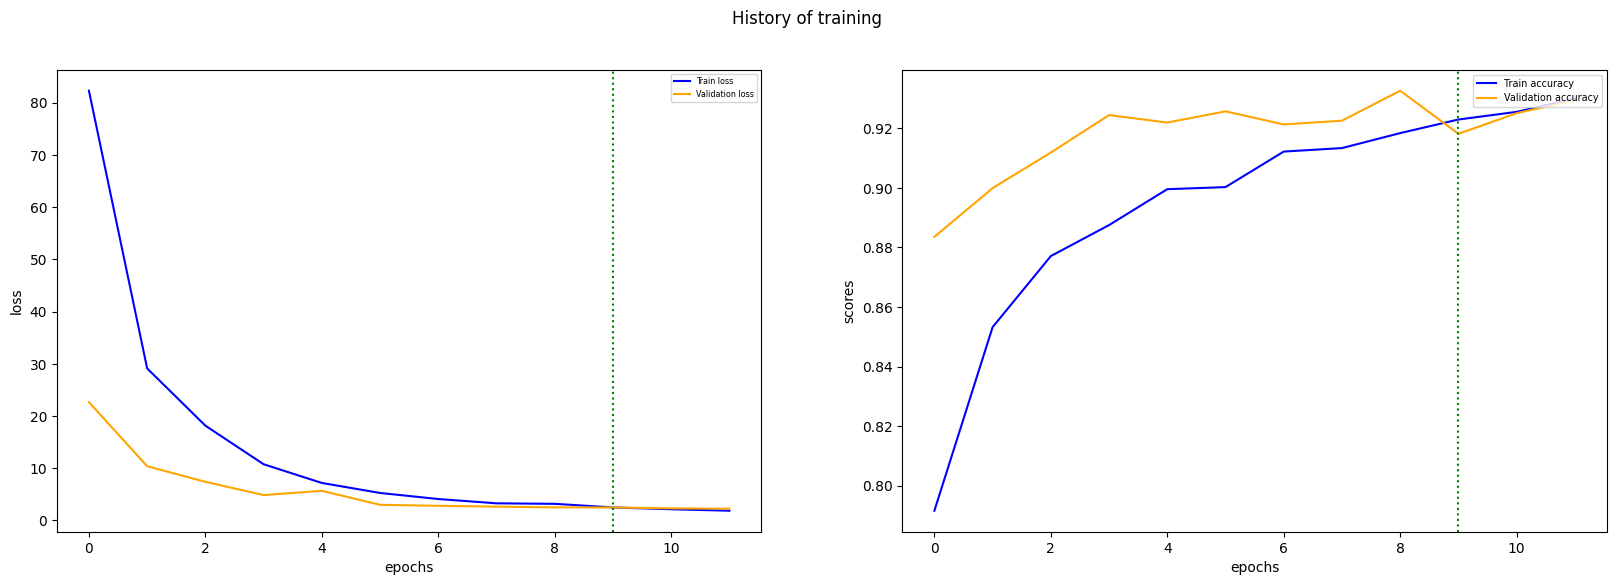

In [71]:
history = torch.load(f'./model/history/history_{triplet_model.name}.pt')
history_plot(history)

In [72]:
triplet_model_best = torch.load(f'./model/best_model_{triplet_model.name}.pt', map_location=DEVICE)['best_model']
triplet_model_best

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [73]:
_, test_accuracy = eval_triplet_epoch(model=triplet_model_best,
                                      val_loader=test_tripletloader,
                                      criterion=loss_fn)
test_accuracy

  0%|          | 0/59 [00:00<?, ?it/s]

0.9222577209797657

In [74]:
test_accuracy_dict['TripletEfficientNetB2_model'] = test_accuracy

In [75]:
def _batch_vizualization(concat, positive_distance, negative_distance):

    """
    Функция визуализации картинок лица, положительного и отрицательного примера батча
    params:
        concat: конкатинация картинок в ряд
        positive_distance: расстояние между позитивным примером
        negative_distance: расстояние между отрицательным примером
    """
    
    grid = torchvision.utils.make_grid(concat).numpy().transpose((1, 2, 0))

    # Денормализация фотографии (так как во время инициализации датасета применялась аугментация)
    aug_normalization = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    grid = grid * aug_normalization[1] + aug_normalization[0]
    grid = grid.clip(0., 1.)

    plt.figure(figsize=(12, 4))
    plt.imshow(grid)
    plt.axis('off')
    plt.title(f'Расстояние эмббедингов между лицом одного человека = {positive_distance:.2f} и лицом другого человека = {negative_distance:.2f}')
    plt.show()

def triplet_vizualization(model, test_dataset, n_batches):

    """
    Функция визуализации картинок лица, положительного и отрицательного примера для нескольких батчей
    params:
        model: объект модели
        test_dataset: подаваемый dataset
        n_batches: количество батчей в dataloader
    """
    
    for i in tqdm(range(n_batches)):
    
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
    
        model.eval()
        for anch, pos, neg in tqdm(test_loader):
            concat = torch.cat((anch, pos, neg), 0)
            anch_img, pos_img, neg_img = anch.to(DEVICE), pos.to(DEVICE), neg.to(DEVICE)
    
        with torch.no_grad():
            anchor = model(anch_img)
            positive = model(pos_img)
            negative = model(neg_img)
    
            positive_distance = F.pairwise_distance(anchor, positive).item()
            negative_distance = F.pairwise_distance(anchor, negative).item()
    
            _batch_vizualization(concat, positive_distance, negative_distance)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1878 [00:00<?, ?it/s]

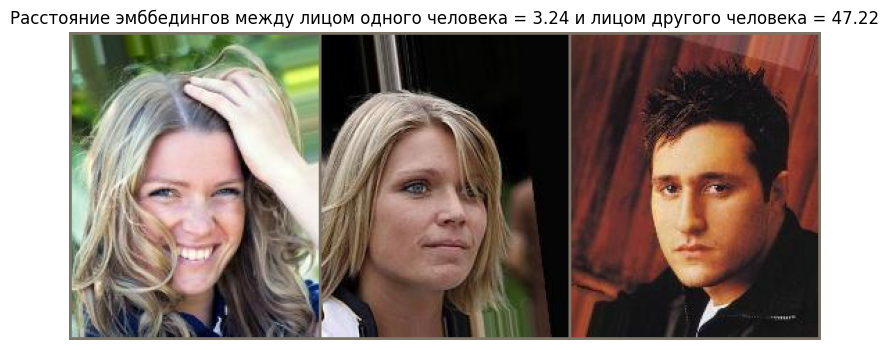

  0%|          | 0/1878 [00:00<?, ?it/s]

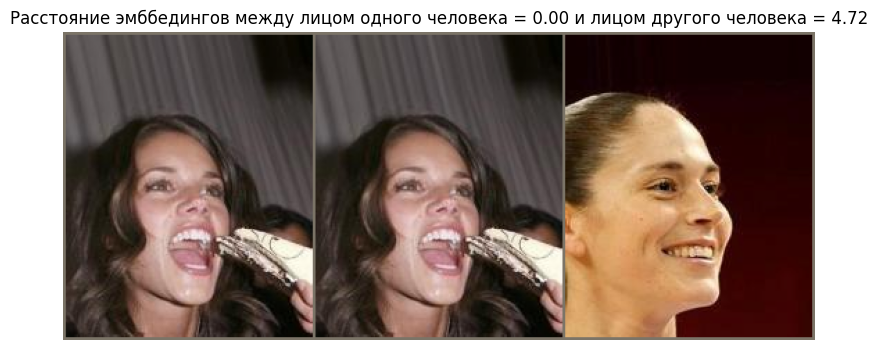

  0%|          | 0/1878 [00:00<?, ?it/s]

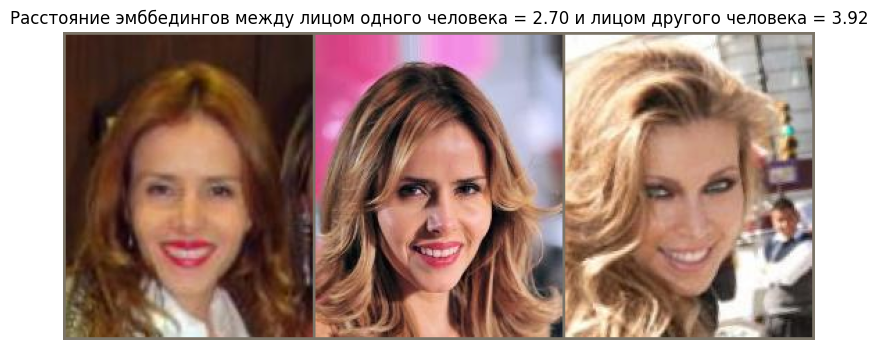

  0%|          | 0/1878 [00:00<?, ?it/s]

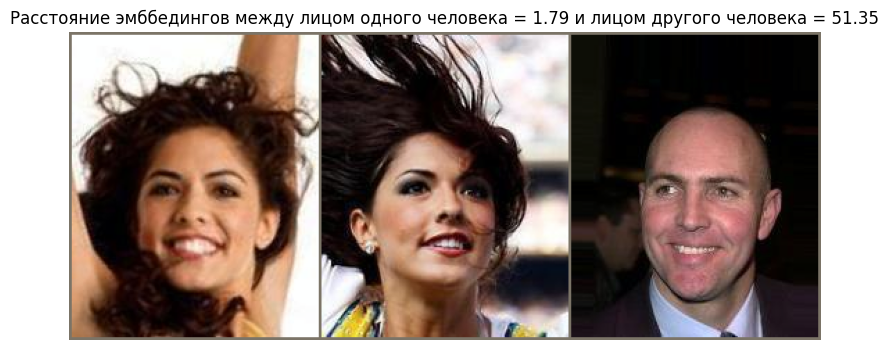

  0%|          | 0/1878 [00:00<?, ?it/s]

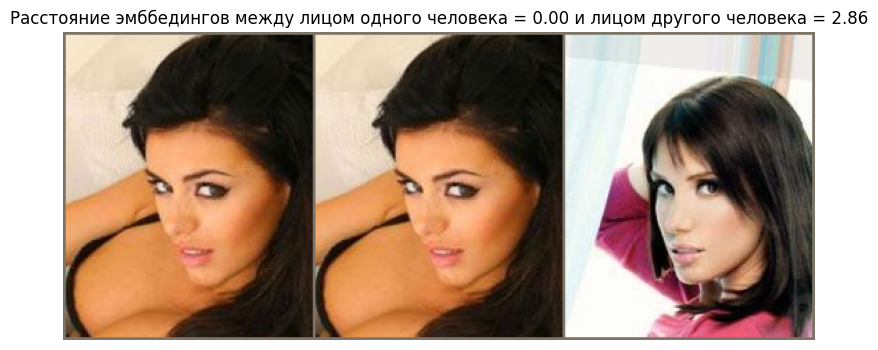

In [76]:
triplet_vizualization(model=triplet_model_best,
                      test_dataset=test_tripletdataset,
                      n_batches=5)

**Вывод:**
* Нагляно посмотрели на расстояния эмбеддингов лиц одного и того же человека, а также и для лиц разных людей. Очень **круто!!!**
* Для одинаковых фото - расстояние = 0, для фото с одним и тем же человеком расстояние всегда меньше, чем расстояние для фото с разными людьми!

---

### 6. Смесь ArcFace loss и Triplet loss (1 балл) 
*  Обучить сеть на смеси ArcFace loss и Triplet loss**. Добиться достаточного качества классификации;

In [77]:
arcface_triplet_model = ArcFaceModel(pretrained_model=efficientnet_b2(pretrained=True),
                                     embedding_size=1000, 
                                     num_classes=N_CLASSES
                                     ).to(DEVICE)

arcface_triplet_model.name = 'ArcFaceTripletModel'
arcface_triplet_model

ArcFaceModel(
  (premodel): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale

In [78]:
arcface_triplet_model.triplet = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features=N_CLASSES, out_features=N_CLASSES*2, bias=True),
    nn.BatchNorm1d(N_CLASSES*2)
)
arcface_triplet_model

ArcFaceModel(
  (premodel): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale

In [79]:
opt = torch.optim.AdamW(arcface_triplet_model.parameters(), lr=1e-3)
loss_fn = TripletLoss()
scheduler_opt = torch.optim.lr_scheduler.StepLR(opt, step_size=3, gamma=0.5)

In [80]:
history = fine_triplet_train(train_loader=train_tripletloader,
                             val_loader=val_tripletloader, 
                             model=arcface_triplet_model, 
                             epochs=EPOCHS,
                             optimizer=opt,
                             criterion=loss_fn,
                             scheduler=scheduler_opt,
                             early_stopping=EARLY_STOPPING
                            )

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 001: 
                      
* train_loss: 73.5423; val_loss: 29.4443; train_acc: 0.7985; val_acc: 0.8861
                      
* BEST validation accuracy: 0.8861; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 002: 
                      
* train_loss: 33.3659; val_loss: 11.8272; train_acc: 0.8587; val_acc: 0.9157
                      
* BEST validation accuracy: 0.9157; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 003: 
                      
* train_loss: 16.1223; val_loss: 11.8419; train_acc: 0.8804; val_acc: 0.9182
                      
* BEST validation accuracy: 0.9182; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 004: 
                      
* train_loss: 9.8511; val_loss: 8.9840; train_acc: 0.8986; val_acc: 0.9119
                      
* BEST validation accuracy: 0.9182; Early stopping counter: 1
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 005: 
                      
* train_loss: 7.9992; val_loss: 4.5573; train_acc: 0.9023; val_acc: 0.9257
                      
* BEST validation accuracy: 0.9257; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 006: 
                      
* train_loss: 7.5820; val_loss: 5.8729; train_acc: 0.9036; val_acc: 0.9125
                      
* BEST validation accuracy: 0.9257; Early stopping counter: 1
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 007: 
                      
* train_loss: 4.9729; val_loss: 7.8551; train_acc: 0.9050; val_acc: 0.9333
                      
* BEST validation accuracy: 0.9333; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 008: 
                      
* train_loss: 3.8495; val_loss: 5.2179; train_acc: 0.9194; val_acc: 0.9251
                      
* BEST validation accuracy: 0.9333; Early stopping counter: 1
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 009: 
                      
* train_loss: 4.6925; val_loss: 3.0028; train_acc: 0.9167; val_acc: 0.9239
                      
* BEST validation accuracy: 0.9333; Early stopping counter: 2
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 010: 
                      
* train_loss: 3.4988; val_loss: 3.7270; train_acc: 0.9164; val_acc: 0.9150
                      
* BEST validation accuracy: 0.9333; Early stopping counter: 3
                   
Stop fine tuning on 10 epoch with best validation accuracy = 0.933291378225299 on 7 epoch.)


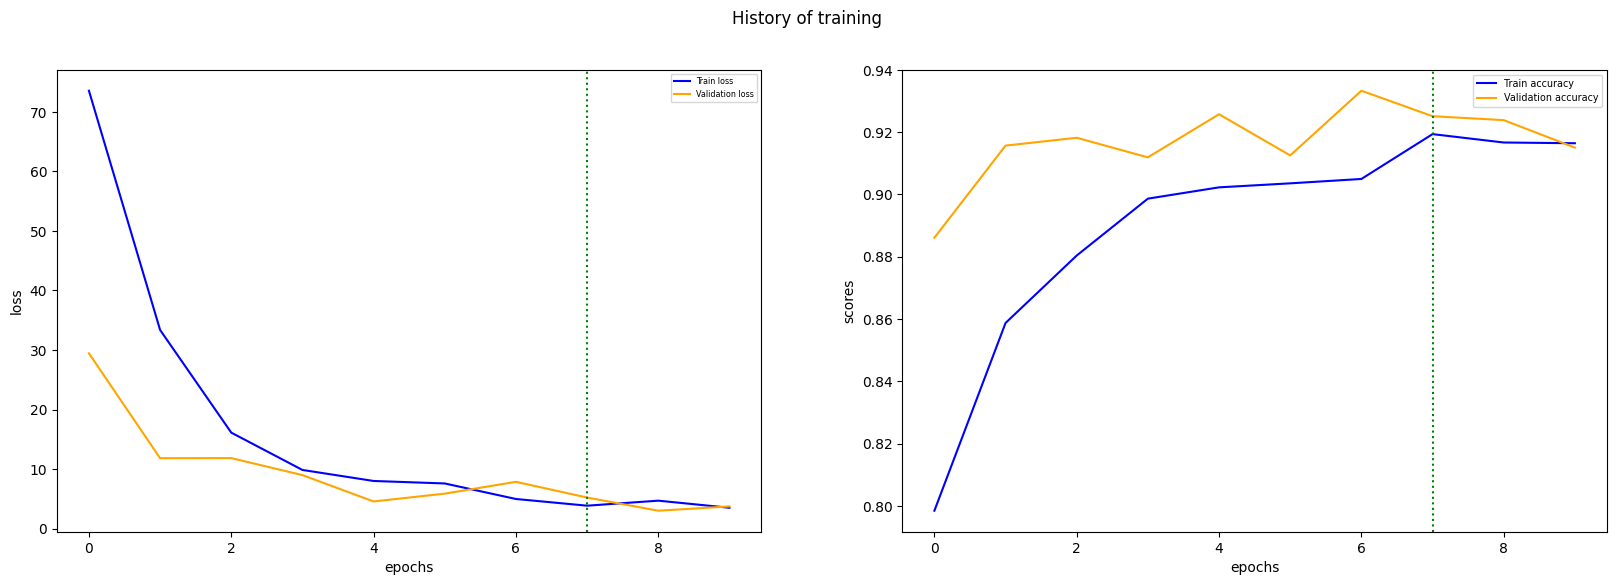

In [81]:
history = torch.load(f'./model/history/history_{arcface_triplet_model.name}.pt')
history_plot(history)

In [82]:
arcface_triplet_model_best = torch.load(f'./model/best_model_{arcface_triplet_model.name}.pt', map_location=DEVICE)['best_model']
arcface_triplet_model_best

ArcFaceModel(
  (premodel): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale

In [83]:
_, test_accuracy = eval_triplet_epoch(model=arcface_triplet_model_best,
                                      val_loader=test_tripletloader,
                                      criterion=loss_fn)
test_accuracy

  0%|          | 0/59 [00:00<?, ?it/s]

0.9254526091586794

In [84]:
test_accuracy_dict['ArcFaceTripletLoss_model'] = test_accuracy

---

## 7. Улучшить сеть с помощью разных трюков (дополнительные баллы) 
*  Например, попробовать другие лосс-функции, поискать статьи с разными улучшениями и попробовать что-то закодить.
    *  Баллы тут зависят от сложности улучшения и вашей иреализации.

### 7.1. CosFase лосс-функция
* chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/1801.09414v2

**Large Margin Cosine Loss (aka CosFace)**
* При этой функции потерь, векторы признаков также нормализуются (аналогично Wj) и масштабируются с помощью постоянного коэффициента s. К косинусу угла добавляется запас m.

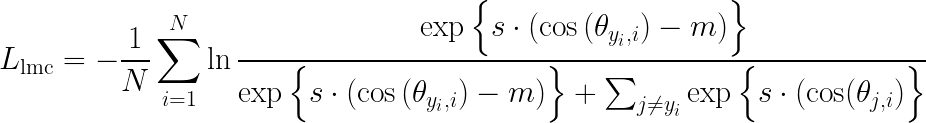



**Преимущества**
* Немонотонность функции косинуса здесь не создает проблемы, в отличие от SphereFace (пункт **7.4**);
* Поскольку вектор признаков также нормализуется, модель должна научиться лучше разделять углы, поскольку у нее нет свободы уменьшать потери путем изучения другой нормы.

In [85]:
class CosFaceLoss(nn.Module):
    
    """
    Класс CosFace лосс-функции
    """
    
    def __init__(self, embedding_size, num_classes, margin=0.6, scale=30):
        super(CosFaceLoss, self).__init__()

        self.embedding_size = embedding_size
        self.num_classes = num_classes
        self.margin = margin
        self.scale = scale
        self.W = nn.Parameter(torch.Tensor(num_classes, embedding_size))
        nn.init.xavier_normal_(self.W)

    def _get_cosine(self, embeddings):
        normalized_embeddings = F.normalize(embeddings)
        normalized_W = F.normalize(self.W)
        cosine = F.linear(normalized_embeddings, normalized_W)

        return cosine

    def forward(self, embeddings, labels):
        cosine = self._get_cosine(embeddings)
        onehot = torch.zeros_like(cosine)
        onehot.scatter_(1, labels.unsqueeze(-1), 1)

        logits = self.scale * (cosine - onehot * self.margin)
        return logits

In [86]:
class FaceModels(nn.Module):

    """
    Класс FaceModels, который позволит реализовывать похожие модели с различными лосс-функциями
    """
    
    def __init__(self, faceloss, pretrained_model, embedding_size, num_classes):
        super(FaceModels, self).__init__()

        self.premodel = copy.deepcopy(pretrained_model)
        self.bachnorm = nn.BatchNorm1d(embedding_size)
        self.facemodel = faceloss(embedding_size=embedding_size, num_classes=num_classes)

    def forward(self, x, labels=None):
        x = self.premodel(x)
        x = self.bachnorm(x)
        if labels is not None:
            x = self.facemodel(x, labels)
        return x

In [87]:
cosface_model = FaceModels(faceloss=CosFaceLoss,
                           pretrained_model=efficientnet_b2(pretrained=True),
                           embedding_size=1000, 
                           num_classes=N_CLASSES
                          ).to(DEVICE)

cosface_model.name = 'CosFaceModel'
cosface_model

FaceModels(
  (premodel): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_a

In [88]:
opt = torch.optim.AdamW(cosface_model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
scheduler_opt = torch.optim.lr_scheduler.StepLR(opt, step_size=3, gamma=0.5)

In [89]:
history = fine_train(train_loader=train_loader,
                     val_loader=val_loader, 
                     model=cosface_model, 
                     epochs=EPOCHS,
                     optimizer=opt,
                     criterion=loss_fn,
                     scheduler=scheduler_opt,
                     early_stopping=EARLY_STOPPING
                    )

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 001: 
                      
* train_loss: 5.9681; val_loss: 4.6267; train_acc: 0.0583; val_acc: 0.2316
                      
* BEST validation accuracy: 0.2316; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 002: 
                      
* train_loss: 4.4321; val_loss: 3.3710; train_acc: 0.2631; val_acc: 0.4619
                      
* BEST validation accuracy: 0.4619; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 003: 
                      
* train_loss: 3.5053; val_loss: 2.5511; train_acc: 0.4574; val_acc: 0.5463
                      
* BEST validation accuracy: 0.5463; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 004: 
                      
* train_loss: 2.7500; val_loss: 1.7179; train_acc: 0.6605; val_acc: 0.6797
                      
* BEST validation accuracy: 0.6797; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 005: 
                      
* train_loss: 2.3434; val_loss: 1.3688; train_acc: 0.7712; val_acc: 0.7420
                      
* BEST validation accuracy: 0.7420; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 006: 
                      
* train_loss: 2.0771; val_loss: 1.3040; train_acc: 0.8391; val_acc: 0.7451
                      
* BEST validation accuracy: 0.7451; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 007: 
                      
* train_loss: 1.7922; val_loss: 1.1056; train_acc: 0.9017; val_acc: 0.7885
                      
* BEST validation accuracy: 0.7885; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 008: 
                      
* train_loss: 1.6442; val_loss: 1.0644; train_acc: 0.9267; val_acc: 0.8037
                      
* BEST validation accuracy: 0.8037; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 009: 
                      
* train_loss: 1.5208; val_loss: 1.0047; train_acc: 0.9453; val_acc: 0.8049
                      
* BEST validation accuracy: 0.8049; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 010: 
                      
* train_loss: 1.4301; val_loss: 0.9406; train_acc: 0.9511; val_acc: 0.8219
                      
* BEST validation accuracy: 0.8219; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 011: 
                      
* train_loss: 1.3764; val_loss: 0.9234; train_acc: 0.9606; val_acc: 0.8175
                      
* BEST validation accuracy: 0.8219; Early stopping counter: 1
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 012: 
                      
* train_loss: 1.3240; val_loss: 0.9280; train_acc: 0.9644; val_acc: 0.8225
                      
* BEST validation accuracy: 0.8225; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 013: 
                      
* train_loss: 1.2586; val_loss: 0.9317; train_acc: 0.9698; val_acc: 0.8244
                      
* BEST validation accuracy: 0.8244; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 014: 
                      
* train_loss: 1.2577; val_loss: 0.9012; train_acc: 0.9703; val_acc: 0.8313
                      
* BEST validation accuracy: 0.8313; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 015: 
                      
* train_loss: 1.2210; val_loss: 0.9033; train_acc: 0.9716; val_acc: 0.8320
                      
* BEST validation accuracy: 0.8320; Early stopping counter: 0
                   


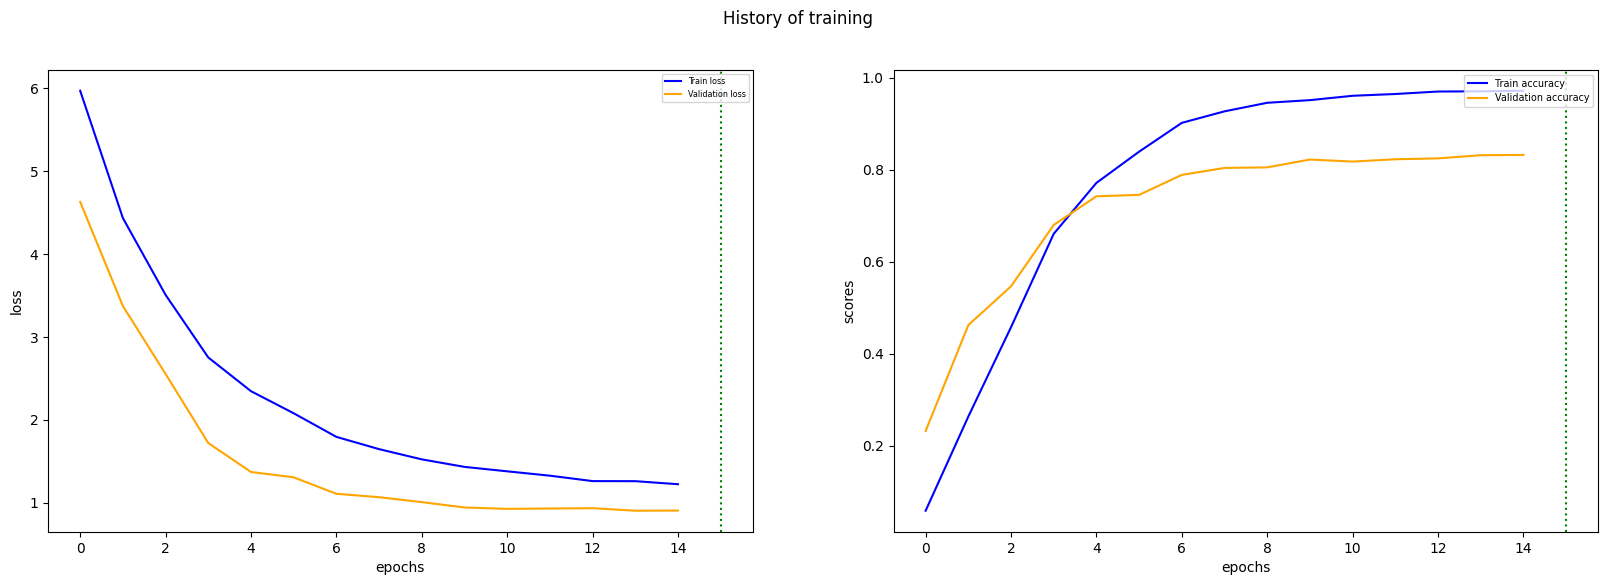

In [90]:
history = torch.load(f'./model/history/history_{cosface_model.name}.pt')
history_plot(history)

In [91]:
cosface_model_best = torch.load(f'./model/best_model_{cosface_model.name}.pt', map_location=DEVICE)['best_model']
cosface_model_best

FaceModels(
  (premodel): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_a

In [92]:
_, test_accuracy = eval_epoch(model=cosface_model_best,
                              val_loader=test_loader,
                              criterion=loss_fn)
test_accuracy

  0%|          | 0/59 [00:00<?, ?it/s]

0.8232161874334398

In [93]:
test_accuracy_dict['CosFaceLoss_model'] = test_accuracy

---

### 7.2. MultiLoss (ArcFace + CosFace)
* Смесь двух функций из пункта **3** и **7.2**

In [94]:
class MultiFaceLoss(nn.Module):
    
    """
    Класс MultiFace лосс-функции
    """
    
    def __init__(self, embedding_size, num_classes, margin1=0.6, margin2=0.6, scale=64, eps=1e-6):
        super(MultiFaceLoss, self).__init__()
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        self.scale = scale
        self.margin1 = margin1
        self.margin2 = margin2
        self.eps = eps
        self.W = nn.Parameter(torch.Tensor(num_classes, embedding_size))
        nn.init.xavier_normal_(self.W)

        self.cos_m1 = math.cos(margin1)
        self.sin_m1 = math.sin(margin1)
        self.theta = math.cos(math.pi - margin1)
        self.sinmm = math.sin(math.pi - margin1) * margin1

    def _get_cosine(self, embeddings):
        normalized_embeddings = F.normalize(embeddings)
        normalized_W = F.normalize(self.W)
        cosine = F.linear(normalized_embeddings, normalized_W)

        return cosine

    def forward(self, embeddings, labels):
        # cos(theta)
        cosine = self._get_cosine(embeddings)
        # cos(theta + m1)
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m1 - sine * self.sin_m1   
        phi = torch.where(cosine > self.theta, phi, cosine - self.sinmm)

        onehot = torch.zeros_like(cosine)
        onehot.scatter_(1, labels.unsqueeze(-1), 1)
        onehot = (1 - self.eps) * onehot + self.eps / self.num_classes
        
        logits = (onehot * phi) + ((1.0 - onehot) * cosine) # additive angular margin
        logits = logits - onehot * self.margin2 # additive cosine margin
        logits = self.scale * logits

        return logits

In [95]:
multiface_model = FaceModels(faceloss=MultiFaceLoss,
                             pretrained_model=efficientnet_b2(pretrained=True),
                             embedding_size=1000, 
                             num_classes=N_CLASSES
                            ).to(DEVICE)

multiface_model.name = 'MultiFaceModel'
multiface_model

FaceModels(
  (premodel): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_a

In [96]:
opt = torch.optim.AdamW(multiface_model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
scheduler_opt = torch.optim.lr_scheduler.StepLR(opt, step_size=3, gamma=0.5)

In [97]:
history = fine_train(train_loader=train_loader,
                     val_loader=val_loader, 
                     model=multiface_model, 
                     epochs=EPOCHS,
                     optimizer=opt,
                     criterion=loss_fn,
                     scheduler=scheduler_opt,
                     early_stopping=EARLY_STOPPING
                    )

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 001: 
                      
* train_loss: 5.9707; val_loss: 4.5414; train_acc: 0.0555; val_acc: 0.2435
                      
* BEST validation accuracy: 0.2435; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 002: 
                      
* train_loss: 4.3432; val_loss: 3.2527; train_acc: 0.2719; val_acc: 0.4462
                      
* BEST validation accuracy: 0.4462; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 003: 
                      
* train_loss: 3.4528; val_loss: 2.3580; train_acc: 0.4607; val_acc: 0.5733
                      
* BEST validation accuracy: 0.5733; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 004: 
                      
* train_loss: 2.6826; val_loss: 1.5882; train_acc: 0.6761; val_acc: 0.7105
                      
* BEST validation accuracy: 0.7105; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 005: 
                      
* train_loss: 2.3101; val_loss: 1.3876; train_acc: 0.7827; val_acc: 0.7351
                      
* BEST validation accuracy: 0.7351; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 006: 
                      
* train_loss: 2.0237; val_loss: 1.2358; train_acc: 0.8441; val_acc: 0.7558
                      
* BEST validation accuracy: 0.7558; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 007: 
                      
* train_loss: 1.7547; val_loss: 1.0273; train_acc: 0.9013; val_acc: 0.8024
                      
* BEST validation accuracy: 0.8024; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 008: 
                      
* train_loss: 1.6041; val_loss: 0.9970; train_acc: 0.9313; val_acc: 0.8018
                      
* BEST validation accuracy: 0.8024; Early stopping counter: 1
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 009: 
                      
* train_loss: 1.5109; val_loss: 0.9733; train_acc: 0.9360; val_acc: 0.8087
                      
* BEST validation accuracy: 0.8087; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 010: 
                      
* train_loss: 1.4009; val_loss: 0.9390; train_acc: 0.9552; val_acc: 0.8156
                      
* BEST validation accuracy: 0.8156; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 011: 
                      
* train_loss: 1.3366; val_loss: 0.9259; train_acc: 0.9620; val_acc: 0.8188
                      
* BEST validation accuracy: 0.8188; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 012: 
                      
* train_loss: 1.2975; val_loss: 0.8990; train_acc: 0.9642; val_acc: 0.8238
                      
* BEST validation accuracy: 0.8238; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 013: 
                      
* train_loss: 1.2470; val_loss: 0.8835; train_acc: 0.9698; val_acc: 0.8282
                      
* BEST validation accuracy: 0.8282; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 014: 
                      
* train_loss: 1.2170; val_loss: 0.8816; train_acc: 0.9728; val_acc: 0.8269
                      
* BEST validation accuracy: 0.8282; Early stopping counter: 1
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 015: 
                      
* train_loss: 1.2064; val_loss: 0.8931; train_acc: 0.9700; val_acc: 0.8269
                      
* BEST validation accuracy: 0.8282; Early stopping counter: 2
                   


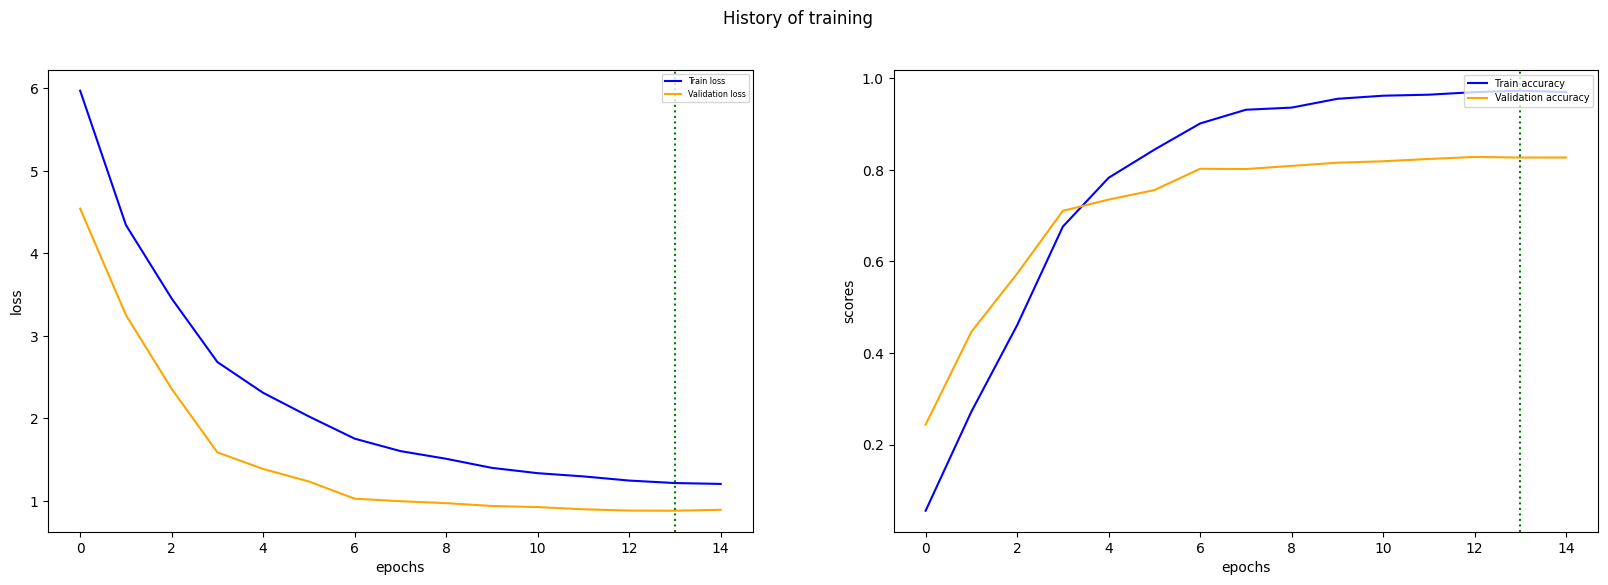

In [98]:
history = torch.load(f'./model/history/history_{multiface_model.name}.pt')
history_plot(history)

In [99]:
multiface_model_best = torch.load(f'./model/best_model_{multiface_model.name}.pt', map_location=DEVICE)['best_model']
multiface_model_best

FaceModels(
  (premodel): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_a

In [100]:
_, test_accuracy = eval_epoch(model=multiface_model_best,
                              val_loader=test_loader,
                              criterion=loss_fn)
test_accuracy

  0%|          | 0/59 [00:00<?, ?it/s]

0.8429179978700746

In [101]:
test_accuracy_dict['CosArcFace_model'] = test_accuracy

---

### 7.4. SphereLoss
* Литература: chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/1704.08063

**A-Softmax (aka SphereFace)**

* Авторы переформулировали выражение для потерь softmax с точки зрения угла между вектором признаков и вектором-столбцом, соответствующим его классу в матрице весов:
  
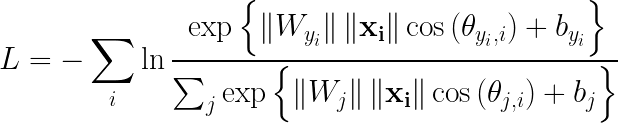

* Затем они упрощают выражение, нормализуя L2 каждый Wj и игнорируя члены смещения. Это по-прежнему работает как хорошее приближение:

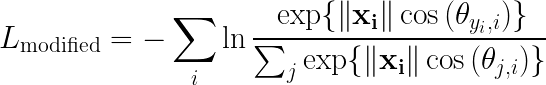

* Затем они добавляют гиперпараметр m, чтобы контролировать чувствительность этого выражения к углу:

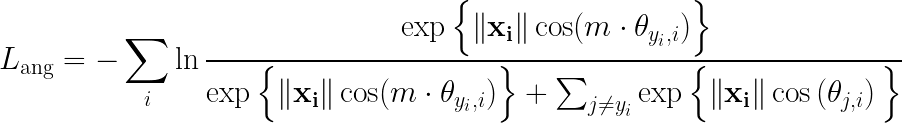

**Преимущества**
* Эта функция потерь работает напрямую с угловыми переменными, что больше соответствует внутреннему распределению данных, как было показано ранее;
* Он не требует сложной перекомпоновки обучающих примеров в пары или тройки;
* Эта функция помогает одновременно уменьшить расстояние внутри класса и увеличить расстояние между классами (это ясно видно в знаменателе, поскольку угол внутри класса получает более крутой штраф, чем угол между классами);

**Недостатки**
* В оригинальной статье делается несколько приближений и предположений (например, m ограничено целым числом);
* По мере увеличения m локальные минимумы косинус-функции также попадают в диапазон возможных θ, после чего функция становится немонотонной (т. е. после θ = /m);
* Чтобы решить эту проблему, авторам необходимо использовать кусочную модификацию исходной функции потерь.

In [106]:
class SphereFaceLoss(nn.Module):
    
    """
    Класс SphereFace лосс-функции
    """
    
    def __init__(self, embedding_size, num_classes, m=2, base=500.0, gamma=0.001, power=2, lambda_min=5.0, iter=0):
        super(SphereFaceLoss, self).__init__()
        
        assert m in [1, 2, 3, 4], 'margin should be 1, 2, 3 or 4'
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        self.m = m
        self.base = base
        self.gamma = gamma
        self.power = power
        self.lambda_min = lambda_min
        self.iter = iter
        self.W = nn.Parameter(torch.Tensor(num_classes, embedding_size))
        nn.init.xavier_normal_(self.W)

        # duplication formula
        self.margin_formula = [
            lambda x : x ** 0,
            lambda x : x ** 1,
            lambda x : 2 * x ** 2 - 1,
            lambda x : 4 * x ** 3 - 3 * x,
            lambda x : 8 * x ** 4 - 8 * x ** 2 + 1,
            lambda x : 16 * x ** 5 - 20 * x ** 3 + 5 * x
        ]

    def _get_cosine(self, embeddings):
        normalized_embeddings = F.normalize(embeddings)
        normalized_W = F.normalize(self.W)
        cosine = F.linear(normalized_embeddings, normalized_W)

    def forward(self, embeddings, labels):
        self.iter += 1
        self.cur_lambda = max(self.lambda_min, self.base * (1 + self.gamma * self.iter) ** (-1 * self.power))

        cos_theta = self._get_cosine(embeddings)
        cos_theta = cos_theta(-1, 1)

        cos_m_theta = self.margin_formula(self.m)(cos_theta)
        theta = cos_theta.data.acos()
        k = ((self.m * theta) / math.pi).floor()
        phi_theta = ((-1.0) ** k) * cos_m_theta - 2 * k
        phi_theta_ = (self.cur_lambda * cos_theta + phi_theta) / (1 + self.cur_lambda)
        norm_of_feature = torch.norm(input, 2, 1)

        onehot = torch.zeros_like(cos_theta)
        onehot.scatter_(1, labels.unsqueeze(-1), 1)

        logits = onehot * phi_theta_ + (1 - onehot) * cos_theta
        logits = norm_of_feature.unsqueeze(-1) * logits

        return logits

In [107]:
sphereface_model = FaceModels(faceloss=SphereFaceLoss,
                              pretrained_model=efficientnet_b2(pretrained=True),
                              embedding_size=1000, 
                              num_classes=N_CLASSES
                              ).to(DEVICE)

sphereface_model.name = 'SphereFaceModel'
sphereface_model

FaceModels(
  (premodel): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_a

In [108]:
opt = torch.optim.AdamW(sphereface_model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
scheduler_opt = torch.optim.lr_scheduler.StepLR(opt, step_size=3, gamma=0.5)

In [109]:
sphereface_history = fine_train(train_loader=train_loader,
                                val_loader=val_loader, 
                                model=sphereface_model, 
                                epochs=EPOCHS,
                                optimizer=opt,
                                criterion=loss_fn,
                                scheduler=scheduler_opt,
                                early_stopping=EARLY_STOPPING,
                                save=False
                                )

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 001: 
                      
* train_loss: 6.1000; val_loss: 4.8161; train_acc: 0.0447; val_acc: 0.2096
                      
* BEST validation accuracy: 0.2096; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 002: 
                      
* train_loss: 4.4748; val_loss: 3.4892; train_acc: 0.2438; val_acc: 0.3675
                      
* BEST validation accuracy: 0.3675; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 003: 
                      
* train_loss: 3.5587; val_loss: 2.4399; train_acc: 0.4405; val_acc: 0.5607
                      
* BEST validation accuracy: 0.5607; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 004: 
                      
* train_loss: 2.7625; val_loss: 1.6703; train_acc: 0.6541; val_acc: 0.6910
                      
* BEST validation accuracy: 0.6910; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 005: 
                      
* train_loss: 2.3601; val_loss: 1.4534; train_acc: 0.7717; val_acc: 0.7319
                      
* BEST validation accuracy: 0.7319; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 006: 
                      
* train_loss: 2.0776; val_loss: 1.2881; train_acc: 0.8416; val_acc: 0.7539
                      
* BEST validation accuracy: 0.7539; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 007: 
                      
* train_loss: 1.7976; val_loss: 1.0629; train_acc: 0.9018; val_acc: 0.7885
                      
* BEST validation accuracy: 0.7885; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 008: 
                      
* train_loss: 1.6547; val_loss: 1.0389; train_acc: 0.9298; val_acc: 0.7948
                      
* BEST validation accuracy: 0.7948; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 009: 
                      
* train_loss: 1.5445; val_loss: 0.9884; train_acc: 0.9411; val_acc: 0.7999
                      
* BEST validation accuracy: 0.7999; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 010: 
                      
* train_loss: 1.4333; val_loss: 0.9542; train_acc: 0.9541; val_acc: 0.8093
                      
* BEST validation accuracy: 0.8093; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 011: 
                      
* train_loss: 1.3726; val_loss: 0.9503; train_acc: 0.9597; val_acc: 0.8188
                      
* BEST validation accuracy: 0.8188; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 012: 
                      
* train_loss: 1.3172; val_loss: 0.9370; train_acc: 0.9671; val_acc: 0.8169
                      
* BEST validation accuracy: 0.8188; Early stopping counter: 1
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 013: 
                      
* train_loss: 1.2786; val_loss: 0.9147; train_acc: 0.9716; val_acc: 0.8225
                      
* BEST validation accuracy: 0.8225; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 014: 
                      
* train_loss: 1.2563; val_loss: 0.8928; train_acc: 0.9721; val_acc: 0.8288
                      
* BEST validation accuracy: 0.8288; Early stopping counter: 0
                   


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 015: 
                      
* train_loss: 1.2257; val_loss: 0.8968; train_acc: 0.9746; val_acc: 0.8238
                      
* BEST validation accuracy: 0.8288; Early stopping counter: 1
                   


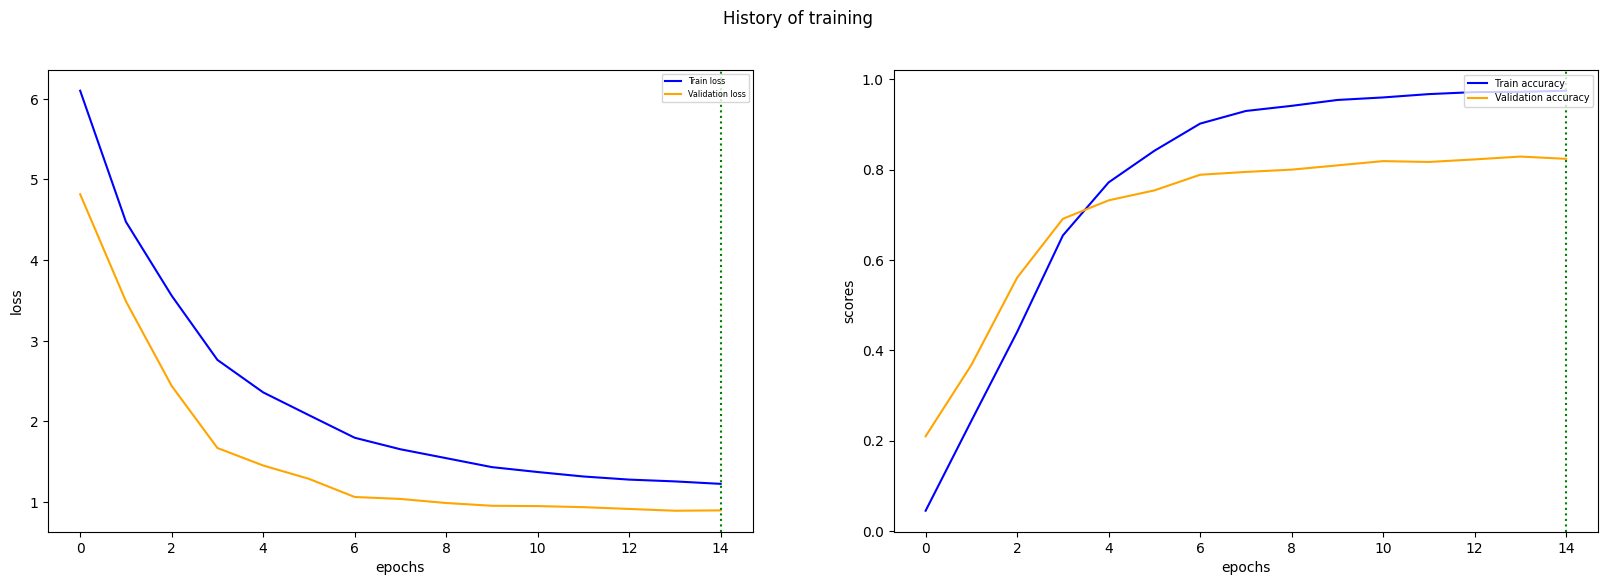

In [110]:
history_plot(sphereface_history)

In [111]:
sphereface_model_best = copy.deepcopy(sphereface_model)
sphereface_model_best

FaceModels(
  (premodel): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_a

In [112]:
_, test_accuracy = eval_epoch(model=sphereface_model_best,
                              val_loader=test_loader,
                              criterion=loss_fn)
test_accuracy

  0%|          | 0/59 [00:00<?, ?it/s]

0.8375931842385517

In [113]:
test_accuracy_dict['SphereFaceLoss_model'] = test_accuracy

---

# Выводы по проекту
### В данной работе были рассмотрены и реализованы следующие пункты:

1) **(2 балла, обязательная часть!)** Обучить нейросеть для 3 части пайплайна (распознавание лиц) на CE loss. Для этого можно использовать нейросети, предобученные на ImageNet. Нельзя брать нейросети, которые уже предобучены на распознавание лиц! Добиться достаточного качества классификации.
2) **(2 балла) Реализовать Identification Rate Metric** (ниже дан щаблон кода для него и ячейки для тестирования);
3) **(2 балла) Реализовать ArcFace loss**, обучить сеть с нуля на нем. Добиться достаточного качества классификации;
4) **(2 балла) Исследовать пространство полученных эмбеддингов**. Например, как в случае Arcface Loss расположены эмбеддинги на сфере? Где расположены эмбеддинги картинок-аутлаеров? (например, если лицо на картинке сильно смазано или почти не видно. Или это вообще не картинка лица). Как еще можно исследовать модель?
5) **(2 балла) Реализовать Triplet loss**, обучить сеть с нуля на нем. Добиться достаточного качества классификации;
6) **(1 балл) Обучить сеть на смеси ArcFace loss и Triplet loss**. Добиться достаточного качества классификации;
7) **Улучшить сеть с помощью разных трюков**. Например, попробовать другие лосс-функции, поискать статьи с разными улучшениями и попробовать что-то закодить. Баллы тут зависят от сложности улучшения и вашей иреализации.

**Все** заметки и промежуточные выводы делал после каждого из пунктов. Во время обучения моделей было реализовано следующее:
- Базовой предобученой моделью является **EfficientNetB2**;
- Для моделей **классификации** изменен последний слой классификатора с двумя dropout'ами и batchnorm. Также была добавлена **аугментация** для train dataloader'а, а именно - изменение размера (размер 384, для efficientnet), перевод в тензор, горизонтальное отображение, изменение яркости и констраста, перевод в серый цвет, размытость, нормализация;
- Для моделей с **contrastive training** изменен последний слой классификатора на droppout, линейный и batchnorm размером 1000. Аугментация на train dataloader осталась такой же как и в моделях классификации *за исключением* изменением размера картинки (так как сильно увеличивало вычислительные ресурсы ~5 раз);
- Во время дообучения моделей реализован *early stopping* = 3 по Accuracy на валидационном множестве;
- Для отображения эмбеддингов в пространстве использован **TNSE**, по результатам которого видно разделение векторов лиц по классам;
- Обучено 7 алгоритмов с различными функциями потерь и с результатом качества на тестовом множестве Accuracy >70%;
- **НИЖЕ** приведена итоговая таблица со всеми функциями потерь, реализованными в данном проекте: 
    * Лучшей моделью является алгоритм с функцией потерь - **ArcFace** + **Triplet** loss и **Accuracy** на тестовом множестве = **92,54%**;
    * Худшей моделью является алгоритм с функцией потерь - **CosFace** loss и **Accuracy** на тестовом множестве = **82,32%**;
    
**P.S.** Спасибо за интересный курс и финальный проект!

In [114]:
pd.DataFrame({'Loss':test_accuracy_dict.keys(), 'Value': test_accuracy_dict.values()}).sort_values('Value', ascending=False)

Loss     Value
3     ArcFaceTripletLoss_model  0.925453
2  TripletEfficientNetB2_model  0.922258
5             CosArcFace_model  0.842918
6         SphereFaceLoss_model  0.837593
1            ArcFaceLoss_model  0.837061
0            CELoss_base_model  0.824281
4            CosFaceLoss_model  0.823216